In [1]:
%matplotlib widget
import os, sys
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

In [2]:
sys.path.append(os.path.dirname(os.getcwd()))
from utils.nb import isnotebook
from utils.viz.viz import plot_fustrum, plot_crs, set_3d_axes_equal

## Findings:

### Solution #1: Triangulation + SVD

- At least two points are needed for each lidar point
- At least four points are needed to stable solution
- Uniformly weighs the lidar point, does not account for how many appearances are picked for a lidar point
- Direct approach, no need for initial guess

### Solution #2: Image point ray and lidar point distance minimization

- The minimum number of appearances or lidar points is less than for Solution #1.
- Not direct approach, need initial guess
- Need an optimizer which can be an issue for a javascript implementation, however a robust optimizer is provided below

### Solution with readjusting the model by defining the lidar points and appearances as tiepoints 


### Comparison on datasets
- Maysville Country Club (MCC) with RTK flight positions: Solution #1 beats #2 due to one point has just two appearances and it's located north east which is far from the rest of the points, which are located south west. So #1 overweighs that point which helps with estimating the orientation. Overall, none of the approaches provide usable result, errors are typically around a meter or more.

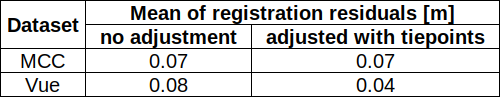


## Utility functions

In [3]:
def image2pixel(p, f, x_c, y_c, width, height):
    # output: coordinates in the image pixels crs which origin is upper left corner (cv standard axis directions)
    K = np.array([[f, 0, x_c + width/2.0], [0, -f, height/2.0 - y_c]])
    p_n = K.dot([p[0], p[1], 1])
    return True, p_n

def distort(p, f, x_c, y_c, k1, k2, k3, t1, t2):
    # p is the image point's normalized coordinates
    # f is the focal length
    # x_c, y_c are the principle point from the image center
    
    r2 = p[0] * p[0] + p[1] * p[1]    
    rp = 1 + k1*r2 + k2*r2*r2 + k3*r2*r2*r2

    rx = p[0] * rp
    ry = p[1] * rp

    tx = t2 * (r2 + 2 * p[0] * p[0]) - 2 * t1 * p[0] * p[1];
    ty = - t1 * (r2 + 2 * p[1] * p[1]) + 2 * t2 * p[0] * p[1];
    
    x = rx + tx;
    y = ry + ty;
    
    return True, np.array([x, y])


In [4]:
def pixel2image(p_d, f, x_c, y_c, width, height):
    K = np.array([[f, 0, x_c + width/2.0], [0, -f, height/2.0 - y_c], [0, 0, 1]])
    p_u = np.linalg.inv(K).dot([p_d[0], p_d[1], 1])
    return True, p_u[:2]

def undistort(p, distort_fn, epsilon=1e-10, max_iter_num=10, verbose=False):
    
    p_u = p.copy()
    
    result, p_d_i = distort_fn(p_u);
    if result == False:
        print('Distortion is unsuccessful!')
        return False, np.one((2, 1)) * np.nan
    delta_p = p_d_i - p_u
    
    epsilon = 1e-10
    iter_num = 0
    while np.max(np.abs(p_u - (p - delta_p))) > epsilon and iter_num < max_iter_num:
        p_u = p - delta_p
        result, p_d_i = distort_fn(p_u)
        if result == False:
            print('Distortion is unsuccessful!')
            return False, np.one((2, 1)) * np.nan
        delta_p = p_d_i - p_u
        iter_num += 1
        
        if verbose:
            num2str = lambda x: str(round(x, 10))
            print('#' + num2str(iter_num) + " x=" + num2str(p_u[0]) + 
                  " y=" + num2str(p_u[0]) + " delta=" + num2str(np.max(np.abs(p_u - (p - delta_p)))))
    
    if iter_num == max_iter_num:
        print('Did not converge!')
        return False, p_u
    
    return True, p_u

In [5]:
def backproject(P_w, C, R, camera2pixel):
    P_c = R @ P_w - R @ C
    
    if P_c[2] == 0:
        print('Divider is zero!')
        return False, np.ones((1, 2)) * np.nan
    
    p_n = [-P_c[0]/P_c[2], -P_c[1]/P_c[2]]
    result, p_d = camera2pixel(p_n)

    if result == False:
        return False, p_d
        
    if (p_d[0] >= 0 and p_d[0] <= width and p_d[1] >= 0 and p_d[1] <= height and 
        f*p_n[0] > -width/2.0*1.25 and f*p_n[0] < width/2.0*1.25 and
        f*p_n[1] > -height/2.0*1.25 and f*p_n[1] < height/2.0*1.25):
        return True, p_d
    else:
        return False, p_d

In [6]:
def triangulate(backprojection_data, pixel2camera, views_rot, views_pos):

    if len(backprojection_data) < 2:
        print('Not enough observations!')
        return False, np.ones((1, 3)) * np.nan
    
    if backprojection_data.shape[1] < 3:
        print('Wrong backprojections array structure')
        return False, np.ones((1, 3)) * np.nan
    
    cam_indices = backprojection_data[:, 0].astype('int')
    img_pts = backprojection_data[:, 1:3]
    n_img_pts = img_pts.shape[0]

    A = np.zeros((n_img_pts*2, 3)) 
    b = np.zeros((n_img_pts*2, 1))
    for k in range(n_img_pts):
        cam_idx = cam_indices[k]
        R = views_rot[cam_idx]
        C = views_pos[cam_idx]
        img_pt = img_pts[k, :]
        
        result, p_c = pixel2camera(img_pt)
        x_i = f*p_c[0];
        y_i = f*p_c[1];
        z_i = -f

        #x_i = img_pt[0] - x_c - width/2.0;
        #y_i = -img_pt[1] - y_c + height/2.0;
        #z_i = -f

        p_i = np.array([x_i, y_i, z_i]).T
        p_i_w = R.T @ p_i

        x_n_w = p_i_w[0] / p_i_w[2]
        y_n_w = p_i_w[1] / p_i_w[2]

        A[k*2, :] = [-1, 0, x_n_w]
        b[k*2] = -C[0] + x_n_w*C[2];

        A[k*2+1, :] = [0, -1, y_n_w]
        b[k*2 + 1] = -C[1] + y_n_w*C[2];

    #P_hat = np.linalg.inv((A.T @ A)) @ A.T @ b
    P_hat = np.linalg.solve(A.T @ A, A.T @ b)
              
    return True, P_hat.T.squeeze(0)

## Problem definition

In [7]:
# Results from seven param
#bundle_mean_offset = np.array([540702.214,126931.369,369.762])
#bundle_data_str = '{"camera":{"focal_length":7471.27,"xo":19.499321327528516,"yo":-6.644968239965986,"pixel_width":7952,"pixel_height":5304,"k1":-0.009478270302244397,"k2":0.04629766820693931,"k3":-0.07699880304345112,"t1":0.00043476760052012665,"t2":0.00023383541355524783},"images":[{"name":"MCC_Flight_01_00002.JPG","position":{"x":82.35928286979,"y":-1.2556541964700036,"z":0.04799140128000081},"rotation":[[0.81146041,-0.57676876,-0.09417958],[0.57067828,0.81676599,-0.08496834],[0.12592976,0.01520221,0.99192267]],"reconstructed":true},{"name":"MCC_Flight_01_00003.JPG","position":{"x":93.12255396163,"y":22.443399079989998,"z":-0.97887273091},"rotation":[[0.77233411,-0.63420716,-0.03579525],[0.62925589,0.77157274,-0.09334093],[0.08681612,0.04956601,0.99499054]],"reconstructed":true},{"name":"MCC_Flight_01_00004.JPG","position":{"x":104.61753521614001,"y":45.666866466170006,"z":-1.6250601033700003},"rotation":[[0.82809178,-0.56037706,0.01554218],[0.56045358,0.82695099,-0.04520893],[0.01248143,0.04614781,0.99885664]],"reconstructed":true},{"name":"MCC_Flight_01_00005.JPG","position":{"x":115.70976815082001,"y":68.92001982130999,"z":-0.603760015349999},"rotation":[[0.79842229,-0.60206282,-0.00649641],[0.59808628,0.79429993,-0.10667909],[0.06938761,0.08128955,0.99427228]],"reconstructed":true},{"name":"MCC_Flight_01_00006.JPG","position":{"x":128.21136057617,"y":91.64647133678001,"z":-1.178327668049997},"rotation":[[0.70597676,-0.64525422,-0.29196542],[0.65153197,0.75332718,-0.08946645],[0.27767409,-0.12706357,0.95223524]],"reconstructed":true},{"name":"MCC_Flight_01_00007.JPG","position":{"x":95.62413725647001,"y":112.64874240729,"z":-4.161914070129999},"rotation":[[-0.97297229,0.18112469,-0.14324372],[-0.18589985,-0.98235329,0.02057312],[-0.13698964,0.04664606,0.98947359]],"reconstructed":true},{"name":"MCC_Flight_01_00008.JPG","position":{"x":83.11172268514,"y":88.55496592428,"z":-3.2256694674400004},"rotation":[[-0.96496574,0.25801613,0.04763179],[-0.25766626,-0.96614035,0.01345077],[0.04948951,0.00070642,0.99877439]],"reconstructed":true},{"name":"MCC_Flight_01_00009.JPG","position":{"x":71.75191918042,"y":65.23237656462,"z":-2.1187321533200003},"rotation":[[-0.98814891,0.15018319,0.03172906],[-0.15066549,-0.98849417,-0.01338614],[0.02935361,-0.01800797,0.99940686]],"reconstructed":true},{"name":"MCC_Flight_01_00010.JPG","position":{"x":61.26550996637,"y":41.79077550519,"z":-2.11152043601},"rotation":[[-0.992939,0.11146488,-0.04059208],[-0.11101198,-0.9937307,-0.01325245],[-0.04181477,-0.00865267,0.99908791]],"reconstructed":true},{"name":"MCC_Flight_01_00011.JPG","position":{"x":50.31861021579001,"y":18.350054653960004,"z":-2.3090450428200002},"rotation":[[-0.98326587,0.18157097,0.01483965],[-0.18165315,-0.98335291,-0.00438],[0.01379733,-0.00700238,0.99988029]],"reconstructed":true},{"name":"MCC_Flight_01_00012.JPG","position":{"x":39.40508526744,"y":-4.92087957888,"z":-2.28648902663},"rotation":[[-0.98798436,0.15417549,0.01080818],[-0.15433886,-0.98788193,-0.01639552],[0.00814942,-0.01786664,0.99980717]],"reconstructed":true},{"name":"MCC_Flight_01_00013.JPG","position":{"x":28.917448434870003,"y":-28.00198831267,"z":-1.67027076552},"rotation":[[-0.98664305,0.16162299,-0.02033483],[-0.16106783,-0.98658761,-0.0264961],[-0.02434447,-0.02286691,0.99944207]],"reconstructed":true},{"name":"MCC_Flight_01_00014.JPG","position":{"x":18.10250853016,"y":-51.489683263159996,"z":-1.1083055364199998},"rotation":[[-0.98562945,0.16489283,-0.03667337],[-0.16227466,-0.98456422,-0.06557612],[-0.04692032,-0.0586826,0.99717342]],"reconstructed":true},{"name":"MCC_Flight_01_00015.JPG","position":{"x":7.044001513579998,"y":-75.46038759319,"z":-0.7910420265299996},"rotation":[[-0.97013745,0.24254539,0.00225127],[-0.2418597,-0.96660876,-0.0846841],[-0.01836364,-0.08269971,0.99640531]],"reconstructed":true},{"name":"MCC_Flight_01_00016.JPG","position":{"x":-3.161367966759999,"y":-98.16694163632,"z":-1.047512299520001},"rotation":[[-0.97518899,0.2207943,-0.01600983],[-0.21938871,-0.97357662,-0.06338108],[-0.02958098,-0.05829616,0.99786097]],"reconstructed":true},{"name":"MCC_Flight_01_00017.JPG","position":{"x":-13.680380669489999,"y":-121.60292506934,"z":-1.8376736000900002},"rotation":[[-0.95164533,0.1859537,0.24452483],[-0.20343071,-0.97790988,-0.0480439],[0.23018931,-0.09546461,0.96845206]],"reconstructed":true},{"name":"MCC_Flight_01_00018.JPG","position":{"x":-19.76766954484,"y":-146.09661388199999,"z":-1.808656646549999},"rotation":[[-0.96774409,-0.10514983,0.22894298],[0.09280517,-0.99362104,-0.06406585],[0.23421908,-0.04075226,0.97132933]],"reconstructed":true},{"name":"MCC_Flight_01_00019.JPG","position":{"x":-60.14016739468001,"y":-129.04674883909001,"z":-3.1687698907399997},"rotation":[[0.84717226,-0.53068078,-0.02602057],[0.53045558,0.84757149,-0.0154739],[0.03026599,-0.0006937,0.99954164]],"reconstructed":true},{"name":"MCC_Flight_01_00020.JPG","position":{"x":-49.736570234910005,"y":-104.89088013374,"z":-2.761282659330001},"rotation":[[0.84542106,-0.53359383,-0.0232564],[0.53060448,0.84406466,-0.07754825],[0.06100917,0.05322097,0.99671732]],"reconstructed":true},{"name":"MCC_Flight_01_00021.JPG","position":{"x":-38.908213667800005,"y":-81.43625905133,"z":-2.5203271780200005},"rotation":[[0.8442514,-0.53579632,-0.01272295],[0.5330382,0.84190221,-0.08408887],[0.05576598,0.06421032,0.99637703]],"reconstructed":true},{"name":"MCC_Flight_01_00022.JPG","position":{"x":-28.139944134470003,"y":-58.621910630710005,"z":-4.00023137549},"rotation":[[0.78621803,-0.61791256,-0.00672865],[0.61662436,0.78519855,-0.05690025],[0.04044271,0.04058695,0.99835719]],"reconstructed":true},{"name":"MCC_Flight_01_00023.JPG","position":{"x":-17.116907261839998,"y":-35.5339959528,"z":-4.15937099287},"rotation":[[0.75716984,-0.65318285,-0.00678212],[0.65226313,0.7565834,-0.04619912],[0.03530771,0.03055686,0.99890923]],"reconstructed":true},{"name":"MCC_Flight_01_00024.JPG","position":{"x":-6.13455894869,"y":-12.317518911359999,"z":-3.22366808808},"rotation":[[0.77173619,-0.63351649,-0.05549882],[0.62836011,0.7730615,-0.08683022],[0.09791238,0.03213678,0.99467602]],"reconstructed":true},{"name":"MCC_Flight_01_00025.JPG","position":{"x":4.671635682690001,"y":11.0118296232,"z":-3.5716084394900003},"rotation":[[0.80931577,-0.58691602,0.02318541],[0.58694789,0.80659571,-0.06996816],[0.02236418,0.07023496,0.99727975]],"reconstructed":true},{"name":"MCC_Flight_01_00027.JPG","position":{"x":26.250723830640002,"y":57.949367483139994,"z":-5.6961660342},"rotation":[[0.79097984,-0.61184211,-0.00036331],[0.61176565,0.79087133,0.01628892],[-0.00967891,-0.01310647,0.99986726]],"reconstructed":true},{"name":"MCC_Flight_01_00028.JPG","position":{"x":36.59046139074,"y":81.71198875055,"z":-3.6204614655099996},"rotation":[[0.81964818,-0.56499592,-0.09463858],[0.56157756,0.82509063,-0.06209745],[0.11317021,-0.00224884,0.99357307]],"reconstructed":true},{"name":"MCC_Flight_01_00029.JPG","position":{"x":47.732835187730004,"y":104.71528108113,"z":-1.0625982732299992},"rotation":[[0.83553571,-0.54377853,0.0786447],[0.54943314,0.82645476,-0.12286477],[0.00181494,0.14586791,0.98930241]],"reconstructed":true},{"name":"MCC_Flight_01_00030.JPG","position":{"x":58.05423845682001,"y":128.09979489012,"z":-0.33234166097999956},"rotation":[[0.84313462,-0.50369388,-0.18819272],[0.47703803,0.86219713,-0.17044304],[0.24811034,0.05393134,0.96722938]],"reconstructed":true},{"name":"MCC_Flight_01_00031.JPG","position":{"x":73.81205143818,"y":148.43108441463,"z":-1.7613095092000006},"rotation":[[0.48994682,-0.87092278,0.0380214],[0.86912117,0.48461714,-0.09886663],[0.06767938,0.08148459,0.99437406]],"reconstructed":true},{"name":"MCC_Flight_01_00032.JPG","position":{"x":33.71100522276999,"y":162.29130884767997,"z":-0.27557475638000467},"rotation":[[-0.91442764,0.39851035,-0.0707926],[-0.38480167,-0.91019153,-0.15322876],[-0.12549807,-0.1128755,0.98565174]],"reconstructed":true},{"name":"MCC_Flight_01_00033.JPG","position":{"x":20.792106151920002,"y":139.80343628855,"z":0.08292356957000173},"rotation":[[-0.96833394,0.23055771,0.09577333],[-0.244152,-0.95465062,-0.17038779],[0.05214585,-0.18837553,0.98071172]],"reconstructed":true},{"name":"MCC_Flight_01_00034.JPG","position":{"x":9.98542457119,"y":115.78698611406,"z":0.21530175024000112},"rotation":[[-0.97833145,0.20405235,-0.03507447],[-0.19776487,-0.97112384,-0.1334449],[-0.0612914,-0.12361684,0.99043538]],"reconstructed":true},{"name":"MCC_Flight_01_00035.JPG","position":{"x":-0.5902691800900055,"y":92.26248659463,"z":0.3127222925699977},"rotation":[[-0.95594374,0.29299429,-0.0180531],[-0.28705537,-0.94588958,-0.15130141],[-0.06140669,-0.1394534,0.98832281]],"reconstructed":true},{"name":"MCC_Flight_01_00036.JPG","position":{"x":-11.638147093810003,"y":68.93972822484999,"z":-0.013600150680000188},"rotation":[[-0.99245868,0.12092224,-0.02008915],[-0.1182826,-0.98773201,-0.10195438],[-0.03217125,-0.09880931,0.99458621]],"reconstructed":true},{"name":"MCC_Flight_01_00037.JPG","position":{"x":-22.34653497239,"y":45.66889990758,"z":-0.66268300874},"rotation":[[-0.98547674,0.16005639,0.05672345],[-0.16666303,-0.97566928,-0.14245314],[0.0325428,-0.14983796,0.98817486]],"reconstructed":true},{"name":"MCC_Flight_01_00038.JPG","position":{"x":-32.81013874898,"y":21.782266128519996,"z":-2.22101869584},"rotation":[[-0.97509809,0.21911882,-0.03421473],[-0.21776232,-0.97520778,-0.03936188],[-0.0419914,-0.03093102,0.99863907]],"reconstructed":true},{"name":"MCC_Flight_01_00039.JPG","position":{"x":-43.53822496787999,"y":-1.5894559828100001,"z":-2.4054093520400004},"rotation":[[-0.97617853,0.21539647,0.02607355],[-0.21601095,-0.97610546,-0.02360933],[0.02036517,-0.02867909,0.99938119]],"reconstructed":true},{"name":"MCC_Flight_01_00040.JPG","position":{"x":-53.916672392699994,"y":-25.18909294514,"z":-1.014597333859999},"rotation":[[-0.97685412,0.15145382,-0.1510555],[-0.13843167,-0.98596314,-0.0933454],[-0.16307267,-0.07027398,0.98410816]],"reconstructed":true},{"name":"MCC_Flight_01_00041.JPG","position":{"x":-64.76839461377999,"y":-48.30428692779,"z":-1.0477234264099993},"rotation":[[-0.97897536,0.20382939,-0.00779894],[-0.20149134,-0.97228371,-0.11859861],[-0.03175666,-0.1145337,0.99291165]],"reconstructed":true},{"name":"MCC_Flight_01_00042.JPG","position":{"x":-75.66813160874001,"y":-71.59243443940001,"z":-1.8515199376600002},"rotation":[[-0.95284755,0.29670696,-0.06361237],[-0.28749935,-0.94977412,-0.12358499],[-0.09708591,-0.09946914,0.99029299]],"reconstructed":true},{"name":"MCC_Flight_01_00043.JPG","position":{"x":-87.09186540655,"y":-95.19713373465,"z":-3.1332040956699996},"rotation":[[-0.96144467,0.27294971,0.03350534],[-0.27471375,-0.95883661,-0.07186595],[0.01251035,-0.07829951,0.99685138]],"reconstructed":true},{"name":"MCC_Flight_01_00044.JPG","position":{"x":-96.024894215,"y":-119.05548145175001,"z":-2.1481782728599987},"rotation":[[-0.96091962,0.00411233,0.27679699],[-0.02838935,-0.99608173,-0.08375693],[0.27536799,-0.08834176,0.95727123]],"reconstructed":true},{"name":"MCC_Flight_01_00045.JPG","position":{"x":-100.27709690482,"y":-143.80235793981,"z":-1.921489684049998},"rotation":[[-0.99001498,-0.13769031,0.03019473],[0.13271828,-0.98265987,-0.12948141],[0.04749949,-0.12418114,0.99112201]],"reconstructed":true},{"name":"MCC_Flight_01_00046.JPG","position":{"x":-137.96524991956,"y":-118.62472987883,"z":-5.344320637020001},"rotation":[[0.78692129,-0.61635803,0.02928588],[0.6161882,0.78241995,-0.0901728],[0.03266487,0.08900451,0.99549546]],"reconstructed":true},{"name":"MCC_Flight_01_00047.JPG","position":{"x":-126.52651239014999,"y":-94.56778725398999,"z":-6.51435552789},"rotation":[[0.80168487,-0.59763897,-0.01135899],[0.59645085,0.80105289,-0.05060288],[0.03934141,0.03379249,0.99865426]],"reconstructed":true},{"name":"MCC_Flight_01_00049.JPG","position":{"x":-104.9072177317,"y":-47.66281310437001,"z":-4.70212894917},"rotation":[[0.766177,-0.64102299,-0.04541301],[0.6348236,0.76595913,-0.10151656],[0.09985895,0.04895041,0.99379678]],"reconstructed":true},{"name":"MCC_Flight_01_00050.JPG","position":{"x":-94.58161467375,"y":-24.3822444912,"z":-4.393112088869999},"rotation":[[0.83186022,-0.55498442,0.00092941],[0.55081729,0.82540698,-0.12370788],[0.06788881,0.1034196,0.99231824]],"reconstructed":true}]}'
#gcp_str = '[{"XYZ":[540825.86,127060.95,276.27],"appearances":[["MCC_Flight_01_00007.JPG",3672,4014],["MCC_Flight_01_00006.JPG",4516,610]]},{"XYZ":[540704.79,126897.92,270.62],"appearances":[["MCC_Flight_01_00015.JPG",4887,4302],["MCC_Flight_01_00014.JPG",5410,3107],["MCC_Flight_01_00012.JPG",5858,648],["MCC_Flight_01_00013.JPG",5696,1971],["MCC_Flight_01_00023.JPG",4729,1458],["MCC_Flight_01_00024.JPG",5473,2633],["MCC_Flight_01_00025.JPG",5108,4251],["MCC_Flight_01_00039.JPG",864,1306],["MCC_Flight_01_00040.JPG",2089,2041],["MCC_Flight_01_00041.JPG",640,3417],["MCC_Flight_01_00042.JPG",1165,4983]]},{"XYZ":[540684.4,126880.9,267.57],"appearances":[["MCC_Flight_01_00022.JPG",4103,1463],["MCC_Flight_01_00016.JPG",5570,4650],["MCC_Flight_01_00013.JPG",6653,859],["MCC_Flight_01_00014.JPG",6382,1976],["MCC_Flight_01_00015.JPG",5739,3111],["MCC_Flight_01_00023.JPG",4452,2958],["MCC_Flight_01_00024.JPG",5136,4054],["MCC_Flight_01_00039.JPG",1854,152],["MCC_Flight_01_00040.JPG",3040,962],["MCC_Flight_01_00041.JPG",1562,2268],["MCC_Flight_01_00042.JPG",1034.2571235428882,4353.277428469248]]},{"XYZ":[540653.43,126904.21,270.62],"appearances":[["MCC_Flight_01_00023.JPG",2245,3103],["MCC_Flight_01_00022.JPG",1867,1476],["MCC_Flight_01_00015.JPG",7720,3975],["MCC_Flight_01_00024.JPG",2992,4142],["MCC_Flight_01_00039.JPG",3832,1054],["MCC_Flight_01_00040.JPG",4878,1970],["MCC_Flight_01_00041.JPG",3467,3209],["MCC_Flight_01_00042.JPG",3825,4600],["MCC_Flight_01_00050.JPG",6305,259]]}]'

# Readjusted with lidar points as tiepoints
bundle_mean_offset = np.array([540702.214,126931.369,369.762])
bundle_data_str = '{"camera":{"focal_length":7475.84,"xo":16.898720410714827,"yo":-3.8143881804946758,"pixel_width":7952,"pixel_height":5304,"k1":-0.007766085705971658,"k2":0.03979231245570214,"k3":-0.05740629060190895,"t1":0.0002868898716742599,"t2":0.00007148316521926627},"images":[{"name":"MCC_Flight_01_00002.JPG","position":{"x":83.34562825747001,"y":-0.8823152326499977,"z":1.6453483799000013},"rotation":[[0.81480497,-0.57164445,-0.0965167],[0.56551537,0.82037412,-0.08472703],[0.12761355,0.01445433,0.99171864]],"reconstructed":true},{"name":"MCC_Flight_01_00003.JPG","position":{"x":94.07928516452999,"y":23.138884945189993,"z":0.612233399030002},"rotation":[[0.77615984,-0.6293834,-0.03811086],[0.62429166,0.77555349,-0.09368405],[0.08852019,0.0489215,0.99487228]],"reconstructed":true},{"name":"MCC_Flight_01_00004.JPG","position":{"x":105.57173717185,"y":46.71812621159,"z":-0.01841935005000003},"rotation":[[0.83162035,-0.55518841,0.01316916],[0.55515045,0.83046893,-0.04614467],[0.0146824,0.04568571,0.99884796]],"reconstructed":true},{"name":"MCC_Flight_01_00005.JPG","position":{"x":116.62398391733001,"y":70.23906340692999,"z":1.02975504632},"rotation":[[0.80219222,-0.59700065,-0.00882399],[0.59279349,0.7981299,-0.10763155],[0.0712988,0.08111038,0.99415169]],"reconstructed":true},{"name":"MCC_Flight_01_00006.JPG","position":{"x":129.10463945632,"y":93.39453137647997,"z":0.4752583023599989},"rotation":[[0.70959102,-0.64076775,-0.29308236],[0.64631925,0.75756737,-0.09145006],[0.28062788,-0.12453263,0.95170353]],"reconstructed":true},{"name":"MCC_Flight_01_00007.JPG","position":{"x":96.17471338622,"y":114.51365775158001,"z":-2.6640396225400016},"rotation":[[-0.97460563,0.1743285,-0.14054696],[-0.17936041,-0.98349384,0.02386862],[-0.13406609,0.04847105,0.98978626]],"reconstructed":true},{"name":"MCC_Flight_01_00008.JPG","position":{"x":83.52988402042,"y":89.99414701053,"z":-1.70237265349},"rotation":[[-0.96655907,0.25175695,0.0488057],[-0.25129251,-0.9677866,0.01553007],[0.05114331,0.00274622,0.99868755]],"reconstructed":true},{"name":"MCC_Flight_01_00009.JPG","position":{"x":72.2023859102,"y":66.34796304356999,"z":-0.5628759030799997},"rotation":[[-0.9890354,0.14395709,0.03294427],[-0.14441314,-0.98944596,-0.01189725],[0.03088388,-0.01652439,0.99938638]],"reconstructed":true},{"name":"MCC_Flight_01_00010.JPG","position":{"x":61.78110833922,"y":42.59625553426999,"z":-0.5442251294500002},"rotation":[[-0.99367132,0.10526225,-0.03920685],[-0.10486025,-0.9944124,-0.01217797],[-0.04026966,-0.00798966,0.9991569]],"reconstructed":true},{"name":"MCC_Flight_01_00011.JPG","position":{"x":50.8498170063,"y":18.836717191400002,"z":-0.7368728202500001},"rotation":[[-0.98434503,0.17553375,0.01589888],[-0.17561205,-0.98445265,-0.00365951],[0.01500933,-0.00639425,0.99986691]],"reconstructed":true},{"name":"MCC_Flight_01_00012.JPG","position":{"x":39.98709358079,"y":-4.76656694427,"z":-0.7263966323800001},"rotation":[[-0.98892051,0.14796871,0.01189509],[-0.14815033,-0.98883218,-0.01619848],[0.00936538,-0.01778127,0.99979804]],"reconstructed":true},{"name":"MCC_Flight_01_00013.JPG","position":{"x":29.548717347270003,"y":-28.19575355308,"z":-0.11825664471999991},"rotation":[[-0.98764951,0.15550182,-0.01917353],[-0.15496455,-0.98755376,-0.02689886],[-0.02311771,-0.02359543,0.99945426]],"reconstructed":true},{"name":"MCC_Flight_01_00014.JPG","position":{"x":18.688753139010007,"y":-51.97918309331,"z":0.3928271271600001},"rotation":[[-0.98668668,0.15856058,-0.03616539],[-0.15594617,-0.98553841,-0.06629356],[-0.04615393,-0.05977111,0.99714454]],"reconstructed":true},{"name":"MCC_Flight_01_00015.JPG","position":{"x":7.67525478704,"y":-76.14184281068,"z":0.7694809137199997},"rotation":[[-0.97151311,0.23697114,0.00263775],[-0.23633726,-0.96797147,-0.08471083],[-0.01752075,-0.08292108,0.99640209]],"reconstructed":true},{"name":"MCC_Flight_01_00016.JPG","position":{"x":-2.4244541470599987,"y":-99.11958127603,"z":0.5941302439499996},"rotation":[[-0.97648736,0.21502633,-0.01536629],[-0.21366838,-0.97484894,-0.0633669],[-0.02860536,-0.05859369,0.99787199]],"reconstructed":true},{"name":"MCC_Flight_01_00017.JPG","position":{"x":-13.04166068239,"y":-122.85931912857,"z":-0.08739963225999973},"rotation":[[-0.95283931,0.18059917,0.24388766],[-0.19797976,-0.97900407,-0.04852879],[0.23000276,-0.09452496,0.96858854]],"reconstructed":true},{"name":"MCC_Flight_01_00018.JPG","position":{"x":-19.0589664602,"y":-147.65851744859998,"z":0.08371606226000179},"rotation":[[-0.96743364,-0.11044841,0.22775711],[0.09816264,-0.9930703,-0.06461792],[0.23331577,-0.04015631,0.97157152]],"reconstructed":true},{"name":"MCC_Flight_01_00019.JPG","position":{"x":-59.98694900179001,"y":-130.76376385135,"z":-1.4042477328099996},"rotation":[[0.84998739,-0.52614,-0.02642224],[0.52599004,0.85039291,-0.01289917],[0.02925606,-0.0029337,0.99956764]],"reconstructed":true},{"name":"MCC_Flight_01_00020.JPG","position":{"x":-49.600238160809994,"y":-106.27925942211,"z":-1.09102674432},"rotation":[[0.84833285,-0.52893369,-0.02367544],[0.52606338,0.84710159,-0.07534066],[0.05990572,0.05145918,0.99687675]],"reconstructed":true},{"name":"MCC_Flight_01_00021.JPG","position":{"x":-38.7717375277,"y":-82.54217771257001,"z":-0.8870128960200019},"rotation":[[0.84725311,-0.53102062,-0.01338961],[0.52834086,0.84504886,-0.08214838],[0.05493736,0.06252619,0.99653016]],"reconstructed":true},{"name":"MCC_Flight_01_00022.JPG","position":{"x":-28.10460408443,"y":-59.493146749110004,"z":-2.38282657148},"rotation":[[0.78988683,-0.61320688,-0.00749106],[0.61198949,0.78898467,-0.0545165],[0.03934023,0.03847742,0.99848477]],"reconstructed":true},{"name":"MCC_Flight_01_00023.JPG","position":{"x":-17.07567358482,"y":-35.939597040609996,"z":-2.6113409501200002},"rotation":[[0.76122399,-0.64845098,-0.0070253],[0.64756466,0.76067254,-0.04513655],[0.03461279,0.02980969,0.99895612]],"reconstructed":true},{"name":"MCC_Flight_01_00024.JPG","position":{"x":-6.130789943020001,"y":-12.413628040219999,"z":-1.69648239985},"rotation":[[0.7754392,-0.6289789,-0.05549403],[0.62387822,0.77675482,-0.08618531],[0.097314,0.03220995,0.99473238]],"reconstructed":true},{"name":"MCC_Flight_01_00025.JPG","position":{"x":4.637190673019999,"y":11.102139184839999,"z":-2.0915143604199997},"rotation":[[0.81274677,-0.58217473,0.02269976],[0.58221046,0.81010737,-0.06897123],[0.02176407,0.06927218,0.99736036]],"reconstructed":true},{"name":"MCC_Flight_01_00027.JPG","position":{"x":26.285094055200002,"y":58.64808983156,"z":-4.23696380238},"rotation":[[0.79481342,-0.60685224,-0.00141119],[0.60679572,0.7947029,0.01569268],[-0.00840166,-0.01332906,0.99987587]],"reconstructed":true},{"name":"MCC_Flight_01_00028.JPG","position":{"x":36.53976869891001,"y":82.74399846089001,"z":-2.115426309300001},"rotation":[[0.82312649,-0.55981485,-0.0952372],[0.55626233,0.82861695,-0.06297763],[0.11417097,-0.00113831,0.99346046]],"reconstructed":true},{"name":"MCC_Flight_01_00029.JPG","position":{"x":47.69616208651,"y":106.0258229593,"z":0.4761205522500015},"rotation":[[0.83917466,-0.53831508,0.07747751],[0.5438564,0.82996004,-0.12404253],[0.00247073,0.14622998,0.98924754]],"reconstructed":true},{"name":"MCC_Flight_01_00030.JPG","position":{"x":57.90333986331,"y":129.74753541824,"z":1.1509898171399964},"rotation":[[0.84627,-0.4982347,-0.1886512],[0.47106189,0.86519384,-0.17187298],[0.24885294,0.05658456,0.96688696]],"reconstructed":true},{"name":"MCC_Flight_01_00031.JPG","position":{"x":73.67657588066,"y":150.34796824807,"z":-0.19282253289000048},"rotation":[[0.4960057,-0.86747854,0.03820112],[0.86563264,0.49053417,-0.10028143],[0.06825304,0.0828083,0.99422548]],"reconstructed":true},{"name":"MCC_Flight_01_00032.JPG","position":{"x":33.154122841420005,"y":164.22380797003,"z":1.1702479749700005},"rotation":[[-0.91725754,0.39192195,-0.07096335],[-0.37870008,-0.91337327,-0.14945072],[-0.12338904,-0.11021097,0.98621939]],"reconstructed":true},{"name":"MCC_Flight_01_00033.JPG","position":{"x":20.180115664640002,"y":141.41691300476,"z":1.574428107740004},"rotation":[[-0.96986516,0.22422296,0.09531858],[-0.23765223,-0.95683577,-0.16729234],[0.05369345,-0.18490369,0.98128876]],"reconstructed":true},{"name":"MCC_Flight_01_00034.JPG","position":{"x":9.43548079019,"y":117.04807769867999,"z":1.6978215383899984},"rotation":[[-0.97966935,0.19748012,-0.03534925],[-0.19135072,-0.97272801,-0.13109205],[-0.06027328,-0.12166276,0.99073978]],"reconstructed":true},{"name":"MCC_Flight_01_00035.JPG","position":{"x":-1.115377456660003,"y":93.19711472,"z":1.7593636753299982},"rotation":[[-0.95781163,0.28678598,-0.01872659],[-0.28092499,-0.94800352,-0.1495676],[-0.06064676,-0.13799681,0.98857415]],"reconstructed":true},{"name":"MCC_Flight_01_00036.JPG","position":{"x":-12.14068101764,"y":69.60282483655999,"z":1.4122861627399987},"rotation":[[-0.99317691,0.11474467,-0.02081544],[-0.11211451,-0.98861541,-0.10034894],[-0.03209297,-0.09733054,0.99473454]],"reconstructed":true},{"name":"MCC_Flight_01_00037.JPG","position":{"x":-22.82086241135,"y":46.02671381532999,"z":0.7755274756199998},"rotation":[[-0.98648369,0.15409256,0.05572616],[-0.16056986,-0.97686285,-0.14126677],[0.03266865,-0.1483053,0.98840189]],"reconstructed":true},{"name":"MCC_Flight_01_00038.JPG","position":{"x":-33.2317014612,"y":21.81882053712,"z":-0.78743185908},"rotation":[[-0.97640683,0.21305694,-0.03516308],[-0.21170226,-0.97657116,-0.03861246],[-0.0425659,-0.03025737,0.99863539]],"reconstructed":true},{"name":"MCC_Flight_01_00039.JPG","position":{"x":-43.941776685099995,"y":-1.9020354936499984,"z":-0.9511695300300002},"rotation":[[-0.97753748,0.20928872,0.02487375],[-0.20986254,-0.97745443,-0.02324962],[0.01944707,-0.02794744,0.99942021]],"reconstructed":true},{"name":"MCC_Flight_01_00040.JPG","position":{"x":-54.293803443520005,"y":-25.782310448159997,"z":0.4996074739199989},"rotation":[[-0.97753067,0.14575015,-0.15228486],[-0.13257013,-0.98675971,-0.09343679],[-0.16388699,-0.07114891,0.98391]],"reconstructed":true},{"name":"MCC_Flight_01_00041.JPG","position":{"x":-65.27818778366,"y":-49.217480752,"z":0.4999195304600006},"rotation":[[-0.98005203,0.1984862,-0.01006181],[-0.1958947,-0.97331469,-0.11951479],[-0.03351535,-0.11515966,0.99278143]],"reconstructed":true},{"name":"MCC_Flight_01_00042.JPG","position":{"x":-76.10250420424,"y":-72.79492763096,"z":-0.344432132460001},"rotation":[[-0.95423956,0.29177298,-0.06553926],[-0.28227007,-0.95118669,-0.12476973],[-0.09874451,-0.10056044,0.99001875]],"reconstructed":true},{"name":"MCC_Flight_01_00043.JPG","position":{"x":-87.44081160535,"y":-96.60040578293001,"z":-1.53672000755},"rotation":[[-0.96296115,0.26776637,0.03173309],[-0.26941476,-0.96028098,-0.07263697],[0.01102294,-0.07849594,0.99685349]],"reconstructed":true},{"name":"MCC_Flight_01_00044.JPG","position":{"x":-96.39805144616999,"y":-120.73143497603999,"z":-0.4554417667900032},"rotation":[[-0.96169947,-0.00099297,0.27410426],[-0.02296408,-0.99618603,-0.08417868],[0.27314242,-0.08724914,0.95800877]],"reconstructed":true},{"name":"MCC_Flight_01_00045.JPG","position":{"x":-100.53268096759,"y":-145.75518033404,"z":-0.06739567997000234},"rotation":[[-0.98937033,-0.14275866,0.02768254],[0.13805281,-0.98190046,-0.12966457],[0.04569224,-0.12446462,0.99117142]],"reconstructed":true},{"name":"MCC_Flight_01_00046.JPG","position":{"x":-138.74918938304998,"y":-120.65275630824,"z":-3.67230610276},"rotation":[[0.78991356,-0.61248986,0.02987889],[0.61250268,0.7857016,-0.08668016],[0.02961483,0.08677074,0.99578803]],"reconstructed":true},{"name":"MCC_Flight_01_00047.JPG","position":{"x":-127.2938115934,"y":-96.22794421743998,"z":-4.94664163249},"rotation":[[0.80476376,-0.59350238,-0.01049854],[0.59244899,0.80418271,-0.04789938],[0.03687115,0.03232783,0.99879699]],"reconstructed":true},{"name":"MCC_Flight_01_00049.JPG","position":{"x":-105.74537813898,"y":-48.70518081913001,"z":-3.216289437490001},"rotation":[[0.76971216,-0.63686079,-0.04417608],[0.6309367,0.76944482,-0.09936573],[0.0972732,0.0486107,0.99406988]],"reconstructed":true},{"name":"MCC_Flight_01_00050.JPG","position":{"x":-95.45476815897,"y":-25.116680621690005,"z":-2.98944631855},"rotation":[[0.83511409,-0.55007129,0.00245649],[0.54620553,0.8286997,-0.12213238],[0.06514583,0.10333622,0.99251078]],"reconstructed":true}]}'
gcp_str = '[{"XYZ":[540825.86,127060.95,276.27],"appearances":[["MCC_Flight_01_00006.JPG",4516,610],["MCC_Flight_01_00007.JPG",3672,4014]]},{"XYZ":[540704.79,126897.92,270.62],"appearances":[["MCC_Flight_01_00012.JPG",5858,648],["MCC_Flight_01_00013.JPG",5696,1971],["MCC_Flight_01_00014.JPG",5409,3108],["MCC_Flight_01_00015.JPG",4887,4302],["MCC_Flight_01_00023.JPG",4729,1458],["MCC_Flight_01_00024.JPG",5473,2633],["MCC_Flight_01_00025.JPG",5108,4251],["MCC_Flight_01_00039.JPG",864,1306],["MCC_Flight_01_00040.JPG",2089,2041],["MCC_Flight_01_00041.JPG",640,3417],["MCC_Flight_01_00042.JPG",1165,4983]]},{"XYZ":[540684.4,126880.9,267.57],"appearances":[["MCC_Flight_01_00013.JPG",6653,859],["MCC_Flight_01_00014.JPG",6382,1976],["MCC_Flight_01_00015.JPG",5739,3111],["MCC_Flight_01_00016.JPG",5570,4650],["MCC_Flight_01_00022.JPG",4103,1463],["MCC_Flight_01_00023.JPG",4453,2959],["MCC_Flight_01_00024.JPG",5136,4054],["MCC_Flight_01_00039.JPG",1854,152],["MCC_Flight_01_00040.JPG",3040,962],["MCC_Flight_01_00041.JPG",1562,2268],["MCC_Flight_01_00042.JPG",1079.2637086594968,4371.709779957391]]},{"XYZ":[540653.43,126904.21,270.62],"appearances":[["MCC_Flight_01_00015.JPG",7720,3975],["MCC_Flight_01_00022.JPG",1867,1476],["MCC_Flight_01_00023.JPG",2245,3103],["MCC_Flight_01_00024.JPG",2992,4142],["MCC_Flight_01_00039.JPG",3832,1054],["MCC_Flight_01_00040.JPG",4878,1970],["MCC_Flight_01_00041.JPG",3465,3206],["MCC_Flight_01_00042.JPG",3825,4600],["MCC_Flight_01_00050.JPG",6305,259]]}]'

# Vue: from seven param
#bundle_mean_offset = np.array([454235.211, 4436045.291, 115.731])
#bundle_data_str = '{"camera":{"focal_length":3165.16,"xo":-4.963128111346504,"yo":-4.627177364429638,"pixel_width":6000,"pixel_height":4000,"k1":-0.0018012894964021526,"k2":-0.0012472952261069292,"k3":0.0004546016021401165,"t1":0.000102209075394501,"t2":-0.0000987710746763226},"images":[{"name":"00000000000000003282767105112212_1343681199675926_1343681199681963.jpg","position":{"x":-122.94622500658,"y":18.6535631862,"z":-0.33256540402000195},"rotation":[[0.99664444,0.02794408,0.07693501],[-0.01682025,0.98977978,-0.14160885],[-0.08010584,0.1398396,0.98692854]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681204675451_1343681204681479.jpg","position":{"x":-110.81064220228998,"y":16.696855389250008,"z":-0.21260490854999992},"rotation":[[-0.23416081,0.96811172,0.08904168],[-0.97213273,-0.23422132,-0.0099165],[0.01125518,-0.08888239,0.99597853]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681209675717_1343681209681808.jpg","position":{"x":-85.95725651884,"y":20.24249713171,"z":1.0903865690399999},"rotation":[[-0.23335737,0.9717396,0.03558761],[-0.97195113,-0.23419628,0.02151985],[0.02924617,-0.02956761,0.99913483]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681214676406_1343681214682438.jpg","position":{"x":-61.18929507234,"y":24.01064620805001,"z":1.2914657501000002},"rotation":[[-0.23900959,0.96752621,0.08226454],[-0.97094952,-0.23913399,-0.00848304],[0.01146468,-0.08190224,0.99657442]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681219675037_1343681219681129.jpg","position":{"x":-36.37374597019,"y":27.542414554969998,"z":1.11941518223},"rotation":[[-0.26564178,0.9636985,0.02682612],[-0.96406834,-0.26546334,-0.01007259],[-0.00258559,-0.02853791,0.99958937]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681224675096_1343681224681130.jpg","position":{"x":-11.41835648279,"y":31.469424000140005,"z":1.7514350584500002},"rotation":[[-0.25537391,0.96538861,0.0529999],[-0.96631562,-0.25666026,0.01896404],[0.03191064,-0.04637171,0.99841443]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681229675521_1343681229681550.jpg","position":{"x":13.570439865209998,"y":35.31798562558,"z":1.9925691117100002},"rotation":[[-0.23585888,0.97117327,0.03454073],[-0.97170041,-0.23521342,-0.02174755],[-0.01299619,-0.03869259,0.99916664]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681234676803_1343681234682834.jpg","position":{"x":38.49211141899,"y":39.093394352349996,"z":2.26519013532},"rotation":[[-0.23770458,0.97092808,0.02819916],[-0.97127557,-0.23726143,-0.01818708],[-0.01096777,-0.03171231,0.99943686]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681239675668_1343681239681701.jpg","position":{"x":63.46946789986,"y":42.443814814540005,"z":2.51779078242},"rotation":[[-0.2271949,0.97384558,-0.00269386],[-0.97367734,-0.22720589,-0.01816378],[-0.01830078,-0.00150377,0.9998314]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681244716110_1343681244722145.jpg","position":{"x":86.14300380684,"y":46.21145073842,"z":2.736409668479997},"rotation":[[-0.19551431,0.9795698,0.0470868],[-0.95370462,-0.17872504,-0.24187779],[-0.22852059,-0.09219747,0.96916354]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681249675994_1343681249682030.jpg","position":{"x":92.78822081659,"y":32.129281180629995,"z":1.5215366335200011},"rotation":[[0.93656976,0.32172575,0.13903101],[-0.3318814,0.94161301,0.05674223],[-0.11265797,-0.09928487,0.98866106]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681259675412_1343681259681450.jpg","position":{"x":68.26199881583001,"y":16.47023324263,"z":-0.4378256554799995},"rotation":[[0.18760344,-0.97863531,0.08413015],[0.97326774,0.19675919,0.11847252],[-0.13249477,0.0596553,0.98938687]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681264675219_1343681264681252.jpg","position":{"x":43.59314389066001,"y":13.39279926999,"z":-0.8565576232699994},"rotation":[[0.20076708,-0.97960007,0.00873417],[0.9683481,0.19979497,0.1496126],[-0.14830556,-0.02157957,0.98870612]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681269675983_1343681269682015.jpg","position":{"x":18.957699477159995,"y":9.73892329951,"z":-0.96400302324},"rotation":[[0.20302364,-0.97914671,0.00728882],[0.971495,0.20235633,0.12348836],[-0.12238816,-0.01799,0.99231925]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681274675553_1343681274681582.jpg","position":{"x":-5.94306294111,"y":6.188884795970001,"z":-0.9187474016},"rotation":[[0.20129829,-0.9795262,-0.00272459],[0.97615172,0.20037245,0.08353861],[-0.08128233,-0.01947579,0.99650082]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681279641344_1343681279647382.jpg","position":{"x":-30.447749237260002,"y":2.5851486335200002,"z":-0.6161485387899999},"rotation":[[0.19126837,-0.98147089,0.01145897],[0.97046383,0.19084628,0.14757253],[-0.14702504,-0.01710544,0.98898485]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681284675511_1343681284681540.jpg","position":{"x":-55.4452347689,"y":-1.1113264137599996,"z":-0.8027225049700002},"rotation":[[0.20164166,-0.9794541,-0.00320909],[0.9738485,0.20013528,0.1075405],[-0.10468874,-0.02480981,0.99419553]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681289676188_1343681289682217.jpg","position":{"x":-80.26375137105,"y":-4.92223608045,"z":-0.5043543702500008},"rotation":[[0.20387639,-0.97895141,0.00941074],[0.97633869,0.20402133,0.07168019],[-0.07209141,-0.00542583,0.99738327]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681294676501_1343681294682529.jpg","position":{"x":-104.98094536552,"y":-8.689133274229997,"z":-0.22500903725000015},"rotation":[[0.20101728,-0.97949715,0.01331875],[0.97481294,0.20135977,0.09588527],[-0.0966012,-0.00629131,0.99530328]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681304675811_1343681304681846.jpg","position":{"x":-127.09887891359001,"y":-33.03285266914,"z":-0.2207431133700011},"rotation":[[0.99819298,0.06001464,-0.00300356],[-0.05981203,0.98753738,-0.14557625],[-0.00577058,0.14549284,0.98934248]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681309716724_1343681309722760.jpg","position":{"x":-125.15587110888,"y":-40.88853246766,"z":0.2229504091299993},"rotation":[[0.05135254,0.98715193,-0.15130758],[-0.97092696,0.08481878,0.22384507],[0.23380282,0.13541359,0.96280808]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681314675714_1343681314681750.jpg","position":{"x":-101.33163468498002,"y":-35.750524295620004,"z":1.2054659483499996},"rotation":[[-0.23377247,0.97091788,0.05166142],[-0.97177862,-0.23504446,0.02001057],[0.03157135,-0.04552554,0.99846416]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681319675658_1343681319681692.jpg","position":{"x":-76.47467888788,"y":-31.87523105815,"z":1.83921049969},"rotation":[[-0.24754872,0.96768985,0.04791656],[-0.96861572,-0.24832457,0.01088528],[0.02243244,-0.04371809,0.99879203]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681324675897_1343681324681932.jpg","position":{"x":-51.26421930017,"y":-28.205330290939997,"z":1.94129841528},"rotation":[[-0.24747913,0.96753096,0.05136063],[-0.96848994,-0.2485576,0.0156955],[0.02795196,-0.04585794,0.99855683]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681329675845_1343681329681888.jpg","position":{"x":-26.43969959754,"y":-24.48923778834,"z":1.5537918684900003},"rotation":[[-0.24590515,0.96838258,0.0420218],[-0.96867139,-0.24706967,0.02514609],[0.03473335,-0.03452177,0.9988002]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681334676127_1343681334682161.jpg","position":{"x":-1.6165508075500008,"y":-20.505080727600003,"z":1.42166773116},"rotation":[[-0.24463405,0.96604017,0.08318994],[-0.9692416,-0.2460204,0.00668469],[0.0269241,-0.07899585,0.99651129]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681339675561_1343681339681595.jpg","position":{"x":23.205314513010002,"y":-16.839561244360002,"z":1.2289778992299998},"rotation":[[-0.24834938,0.96057127,0.12500167],[-0.96778723,-0.25155791,0.0103194],[0.04135768,-0.1184122,0.99210286]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681344675169_1343681344681212.jpg","position":{"x":48.05337591335001,"y":-13.141734316699996,"z":0.8813819032999999},"rotation":[[-0.2505194,0.96607925,0.06269695],[-0.96715108,-0.25262959,0.02823254],[0.04311397,-0.05356463,0.99763321]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681349715609_1343681349721652.jpg","position":{"x":73.15133602772,"y":-9.68024413637,"z":1.41446136874},"rotation":[[-0.25597874,0.96616181,0.03172132],[-0.96655343,-0.25634278,0.00792783],[0.01579109,-0.028631,0.99946531]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681354676070_1343681354682109.jpg","position":{"x":96.90609466890001,"y":-5.80320805804,"z":2.217703082069999},"rotation":[[-0.249344,0.96833045,0.01279516],[-0.96058805,-0.24563073,-0.13013892],[-0.1228746,-0.04474024,0.99141321]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681359675833_1343681359681877.jpg","position":{"x":105.04210153800999,"y":-14.780119450889995,"z":1.97091631829},"rotation":[[0.93016176,0.36330166,0.05301886],[-0.36439045,0.93116609,0.01221963],[-0.04492995,-0.0306858,0.99851874]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681364676217_1343681364682260.jpg","position":{"x":109.53958949232,"y":-30.170294125819996,"z":0.7741507006699981},"rotation":[[0.65527626,-0.67328366,0.342494],[0.64989135,0.73359119,0.19870885],[-0.385038,0.0923747,0.91826611]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681369676102_1343681369682134.jpg","position":{"x":87.28136763982,"y":-33.968020042640006,"z":0.5549563766800005},"rotation":[[0.21517219,-0.97552419,-0.04531535],[0.97348466,0.21057073,0.08937327],[-0.0776437,-0.06334444,0.9949668]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681374675636_1343681374681678.jpg","position":{"x":63.67003456659,"y":-37.38849832245,"z":0.7220348075099993},"rotation":[[0.17785171,-0.9839173,0.01659854],[0.97370188,0.17839569,0.14170259],[-0.14238474,-0.00904001,0.98977011]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681379715789_1343681379721832.jpg","position":{"x":55.12532218312,"y":-32.774701272499996,"z":1.0860967463999998},"rotation":[[-0.95487572,-0.27275597,-0.1175438],[0.25430842,-0.95529045,0.15082239],[-0.15342618,0.11412426,0.98154779]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681384676637_1343681384682694.jpg","position":{"x":48.36677927818,"y":-9.275228464660001,"z":1.0102225245000003},"rotation":[[-0.95370785,-0.29613428,-0.05240067],[0.29414792,-0.95481783,0.0424253],[-0.06259668,0.0250478,0.99772454]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681389675918_1343681389681954.jpg","position":{"x":42.00973783700999,"y":14.775935701069999,"z":1.5438998341999999},"rotation":[[-0.94794788,-0.31570344,-0.04154706],[0.31509957,-0.94883653,0.02053064],[-0.04590296,0.00637052,0.99892559]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681394675402_1343681394681423.jpg","position":{"x":35.815976309149995,"y":38.85145491637,"z":2.0964903377099997},"rotation":[[-0.94382071,-0.32762109,-0.04320761],[0.32672345,-0.94474511,0.02661705],[-0.04954049,0.01100479,0.99871149]],"reconstructed":true}]}'
#gcp_str = '[{"XYZ":[454226.02,4436049.7,68.47],"appearances":[["00000000000000003282767105112212_1343681219675037_1343681219681129.jpg",950,3319],["00000000000000003282767105112212_1343681224675096_1343681224681130.jpg",1047,1745],["00000000000000003282767105112212_1343681274675553_1343681274681582.jpg",3058,2522],["00000000000000003282767105112212_1343681279641344_1343681279647382.jpg",3088,1084],["00000000000000003282767105112212_1343681329675845_1343681329681888.jpg",4434,3640],["00000000000000003282767105112212_1343681334676127_1343681334682161.jpg",4400,1949],["00000000000000003282767105112212_1343681339675561_1343681339681595.jpg",4401,434]]},{"XYZ":[454284.63,4436070.85,73.82000000000001],"appearances":[["00000000000000003282767105112212_1343681234676803_1343681234682834.jpg",1768,2520],["00000000000000003282767105112212_1343681239675668_1343681239681701.jpg",2056,694],["00000000000000003282767105112212_1343681259675412_1343681259681450.jpg",1618,3794],["00000000000000003282767105112212_1343681264675219_1343681264681252.jpg",2114,1819],["00000000000000003282767105112212_1343681344675169_1343681344681212.jpg",5498,2917],["00000000000000003282767105112212_1343681349715609_1343681349721652.jpg",5814,1055],["00000000000000003282767105112212_1343681389675918_1343681389681954.jpg",2325,2674],["00000000000000003282767105112212_1343681394675402_1343681394681423.jpg",2488,882]]},{"XYZ":[454323.11,4436004.68,68.98],"appearances":[["00000000000000003282767105112212_1343681349715609_1343681349721652.jpg",574,2499],["00000000000000003282767105112212_1343681354676070_1343681354682109.jpg",735,400],["00000000000000003282767105112212_1343681359675833_1343681359681877.jpg",1124,3281],["00000000000000003282767105112212_1343681369676102_1343681369682134.jpg",3610,2311],["00000000000000003282767105112212_1343681374675636_1343681374681678.jpg",3433,929],["00000000000000003282767105112212_1343681379715789_1343681379721832.jpg",1532,1465]]},{"XYZ":[454150.73,4436015.25,63.74],"appearances":[["00000000000000003282767105112212_1343681289676188_1343681289682217.jpg",4454,2845],["00000000000000003282767105112212_1343681294676501_1343681294682529.jpg",4452,1384],["00000000000000003282767105112212_1343681304675811_1343681304681846.jpg",5661,1510],["00000000000000003282767105112212_1343681314675714_1343681314681750.jpg",2937,3119],["00000000000000003282767105112212_1343681319675658_1343681319681692.jpg",3076,1580],["00000000000000003282767105112212_1343681324675897_1343681324681932.jpg",3221,117]]}]'
 
# Vue: readjusted as tiepoints
#bundle_mean_offset = np.array([454235.211, 4436045.291, 115.731])
#bundle_data_str = '{"camera":{"focal_length":3167.59,"xo":-4.727991187675879,"yo":-0.07840896246371254,"pixel_width":6000,"pixel_height":4000,"k1":-0.000936297706508321,"k2":-0.0011251790203145849,"k3":0.0001377614647246666,"t1":-0.00011848441014557488,"t2":-0.00008123778585072829},"images":[{"name":"00000000000000003282767105112212_1343681199675926_1343681199681963.jpg","position":{"x":-122.63100922128,"y":18.6641327485,"z":-1.162849321910001},"rotation":[[0.99641395,0.02844567,0.07968736],[-0.01671556,0.98941116,-0.144174],[-0.08294469,0.14232497,0.98633857]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681204675451_1343681204681479.jpg","position":{"x":-110.53085158991999,"y":16.662411399990003,"z":-0.9328011939100002},"rotation":[[-0.23457525,0.96830227,0.08582055],[-0.97204174,-0.23459533,-0.00999469],[0.01045522,-0.08576567,0.99626048]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681209675717_1343681209681808.jpg","position":{"x":-85.84335725745999,"y":20.148569006000002,"z":0.51645288233},"rotation":[[-0.2339601,0.9716769,0.03326669],[-0.9718671,-0.23468735,0.01990447],[0.02714798,-0.02767395,0.99924829]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681214676406_1343681214682438.jpg","position":{"x":-61.07797639971,"y":23.92908552016,"z":0.7870180965000002},"rotation":[[-0.23941506,0.96760815,0.0800931],[-0.97085654,-0.2395071,-0.00859818],[0.01086319,-0.07981744,0.9967503]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681219675037_1343681219681129.jpg","position":{"x":-36.293055027150004,"y":27.458614480399998,"z":0.64774059266},"rotation":[[-0.2659091,0.96367525,0.0249472],[-0.96399511,-0.26575464,-0.00937578],[-0.00240537,-0.02654208,0.9996448]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681224675096_1343681224681130.jpg","position":{"x":-11.42014059248,"y":31.358275611300005,"z":1.2749886106400001},"rotation":[[-0.25550563,0.96544205,0.05136647],[-0.96626408,-0.25678255,0.01991102],[0.03241295,-0.0445462,0.99848137]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681229675521_1343681229681550.jpg","position":{"x":13.55016090233,"y":35.21711031211,"z":1.46547091978},"rotation":[[-0.23636808,0.97110026,0.03308204],[-0.97159863,-0.23582157,-0.01960331],[-0.01123532,-0.03677606,0.99926037]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681234676803_1343681234682834.jpg","position":{"x":38.3864022201,"y":38.99440686803,"z":1.6740634666500003},"rotation":[[-0.23840442,0.97079592,0.0268072],[-0.97112497,-0.23804988,-0.01576545],[-0.00892359,-0.02979169,0.9995163]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681239675668_1343681239681701.jpg","position":{"x":63.28852786188,"y":42.38250771679,"z":1.78642629716},"rotation":[[-0.22795058,0.97366097,-0.0047788],[-0.97354988,-0.22799704,-0.01476425],[-0.01546493,0.00128688,0.99987958]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681244716110_1343681244722145.jpg","position":{"x":85.8497223157,"y":46.13350732056001,"z":1.826551866300004},"rotation":[[-0.19643874,0.9794882,0.0448852],[-0.95410006,-0.18039192,-0.23906451],[-0.22606394,-0.0897865,0.96996571]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681249675994_1343681249682030.jpg","position":{"x":92.54184227299999,"y":32.12168924992,"z":0.6770047653800002},"rotation":[[0.9365403,0.32304229,0.13614681],[-0.33292648,0.9412377,0.05684664],[-0.10978264,-0.09856605,0.98905637]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681259675412_1343681259681450.jpg","position":{"x":68.15263800883,"y":16.478718569429997,"z":-1.0383207405700006},"rotation":[[0.18879409,-0.97831245,0.08521471],[0.97319398,0.19799796,0.11700552],[-0.13134029,0.06084049,0.98946863]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681264675219_1343681264681252.jpg","position":{"x":43.548679528440005,"y":13.385569910370002,"z":-1.3639310207299997},"rotation":[[0.20127431,-0.97948681,0.00970806],[0.9682986,0.20045256,0.14905232],[-0.14794079,-0.0206001,0.98878165]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681269675983_1343681269682015.jpg","position":{"x":18.997128727459998,"y":9.711196779,"z":-1.43651010593},"rotation":[[0.20371116,-0.9789972,0.00813967],[0.9713976,0.20315204,0.12294697],[-0.12201833,-0.01713882,0.99237986]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681274675553_1343681274681582.jpg","position":{"x":-5.81211206861,"y":6.18333117493,"z":-1.35162961964},"rotation":[[0.20161682,-0.97946317,-0.0016015],[0.97610317,0.2007893,0.08310396],[-0.08107571,-0.01831839,0.9965396]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681279641344_1343681279647382.jpg","position":{"x":-30.298176111479997,"y":2.57508935831,"z":-1.01796507157},"rotation":[[0.19172322,-0.98136553,0.01280215],[0.97022723,0.19148185,0.14830315],[-0.14799098,-0.01601216,0.98885908]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681284675511_1343681284681540.jpg","position":{"x":-55.24178201822001,"y":-1.1316510736800003,"z":-1.2395542263700003},"rotation":[[0.20205014,-0.97937342,-0.00185623],[0.9736147,0.2006561,0.1086809],[-0.10606672,-0.02376625,0.99407495]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681289676188_1343681289682217.jpg","position":{"x":-79.99546897623,"y":-4.92623433739,"z":-0.9856798399000001},"rotation":[[0.20421392,-0.97886356,0.01108162],[0.97613853,0.20447303,0.07310504],[-0.07382575,-0.00411187,0.99726268]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681294676501_1343681294682529.jpg","position":{"x":-104.60201852382,"y":-8.6995203771,"z":-0.7533007556399979},"rotation":[[0.20143854,-0.97938606,0.01501521],[0.97455033,0.20193615,0.09733159],[-0.09835732,-0.00497326,0.99513874]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681304675811_1343681304681846.jpg","position":{"x":-126.64188272868002,"y":-32.886802795810006,"z":-0.7934877232900001},"rotation":[[0.99812712,0.06112573,-0.0024288],[-0.06081656,0.98722777,-0.14725035],[-0.006603,0.14712228,0.98909627]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681309716724_1343681309722760.jpg","position":{"x":-124.64452027202,"y":-40.75147172172,"z":-0.33320212583999953},"rotation":[[0.05017485,0.98688703,-0.15341601],[-0.97068094,0.08434196,0.22508877],[0.23507659,0.1376242,0.96218427]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681314675714_1343681314681750.jpg","position":{"x":-101.03772363175,"y":-35.65704946766,"z":0.6693102258300001},"rotation":[[-0.23408114,0.97095051,0.04960973],[-0.97170541,-0.23530843,0.02045818],[0.03153747,-0.04341717,0.99855913]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681319675658_1343681319681692.jpg","position":{"x":-76.23953301860999,"y":-31.823329282979998,"z":1.40546154107},"rotation":[[-0.2479528,0.9676414,0.04679244],[-0.96850273,-0.2487335,0.0115802],[0.02284433,-0.04244726,0.99883751]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681324675897_1343681324681932.jpg","position":{"x":-51.159033559090005,"y":-28.16394461766,"z":1.5670784804500002},"rotation":[[-0.24794208,0.96747812,0.05010795],[-0.96838775,-0.2489733,0.01540968],[0.02738407,-0.04470322,0.99862492]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681329675845_1343681329681888.jpg","position":{"x":-26.35088525155,"y":-24.407348553739997,"z":1.2465465801499998},"rotation":[[-0.24614981,0.96840427,0.04004287],[-0.96856735,-0.24730057,0.0268277],[0.03588269,-0.03218058,0.99883775]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681334676127_1343681334682161.jpg","position":{"x":-1.6009868924500001,"y":-20.466850262029997,"z":1.0962731632399998},"rotation":[[-0.24516516,0.96598553,0.08225576],[-0.96907654,-0.24663069,0.00799786],[0.02801261,-0.07775133,0.99657916]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681339675561_1343681339681595.jpg","position":{"x":23.152839163039996,"y":-16.81696555685,"z":0.8463903154200002},"rotation":[[-0.24921784,0.96045723,0.12414662],[-0.967517,-0.25254215,0.01154636],[0.04244204,-0.11723641,0.9921967]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681344675169_1343681344681212.jpg","position":{"x":47.99872227675,"y":-13.0896618129,"z":0.40687529390000005},"rotation":[[-0.25129057,0.96592303,0.06201415],[-0.96682391,-0.25352914,0.0312171],[0.04587571,-0.0521122,0.99758696]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681349715609_1343681349721652.jpg","position":{"x":72.94296503304,"y":-9.632996263540003,"z":0.8083821476200004},"rotation":[[-0.25712361,0.965863,0.03156112],[-0.96621803,-0.25753895,0.00981825],[0.0176113,-0.02797042,0.9994536]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681354676070_1343681354682109.jpg","position":{"x":96.59018555133001,"y":-5.72784723981,"z":1.5270749173900027},"rotation":[[-0.25046902,0.96804736,0.0122304],[-0.96055175,-0.24691295,-0.12796223],[-0.12085365,-0.04379851,0.99170363]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681359675833_1343681359681877.jpg","position":{"x":104.74849097767,"y":-14.608249491010001,"z":1.2861877290500001},"rotation":[[0.92971347,0.36467363,0.05143942],[-0.36573784,0.93063084,0.01273097],[-0.04322846,-0.0306495,0.99859497]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681364676217_1343681364682260.jpg","position":{"x":109.28357441325,"y":-29.952110578169993,"z":0.12224187569000607},"rotation":[[0.65690607,-0.67214621,0.34160487],[0.64887368,0.73472026,0.19786128],[-0.38397572,0.09168213,0.91878019]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681369676102_1343681369682134.jpg","position":{"x":87.16214692918001,"y":-33.796048250679995,"z":-0.05758169493999946},"rotation":[[0.21654842,-0.9752195,-0.04531792],[0.97326941,0.21201197,0.08830391],[-0.07650776,-0.06322862,0.99506216]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681374675636_1343681374681678.jpg","position":{"x":63.66283858187,"y":-37.22174338164,"z":0.24625895669999923},"rotation":[[0.17944003,-0.98362314,0.01693491],[0.97365439,0.18003095,0.13994995],[-0.14070682,-0.00862387,0.99001375]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681379715789_1343681379721832.jpg","position":{"x":55.07030152793,"y":-32.724746444459996,"z":0.5972143201100001},"rotation":[[-0.95475747,-0.27388976,-0.11585579],[0.25559681,-0.95490336,0.15109549],[-0.15201459,0.11464718,0.98170647]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681384676637_1343681384682694.jpg","position":{"x":48.32981477924999,"y":-9.259228300910005,"z":0.5171076842999995},"rotation":[[-0.95351197,-0.29711907,-0.05035063],[0.29511453,-0.95446679,0.04359532],[-0.06101101,0.02670946,0.99777967]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681389675918_1343681389681954.jpg","position":{"x":41.96294485094001,"y":14.697221739040002,"z":0.99657355948},"rotation":[[-0.94777827,-0.3164407,-0.03976973],[0.31580069,-0.9485791,0.02162461],[-0.04456764,0.00793602,0.99897485]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681394675402_1343681394681423.jpg","position":{"x":35.762450969519996,"y":38.68316275521,"z":1.5167449422899997},"rotation":[[-0.94363671,-0.32836592,-0.04154002],[0.32742284,-0.94446405,0.02796335],[-0.04841526,0.01278609,0.99874545]],"reconstructed":true}]}'
#gcp_str = '[{"XYZ":[454323.11,4436004.68,68.98],"appearances":[["00000000000000003282767105112212_1343681349715609_1343681349721652.jpg",574,2499],["00000000000000003282767105112212_1343681354676070_1343681354682109.jpg",735,400],["00000000000000003282767105112212_1343681359675833_1343681359681877.jpg",1124,3281],["00000000000000003282767105112212_1343681369676102_1343681369682134.jpg",3610,2311],["00000000000000003282767105112212_1343681374675636_1343681374681678.jpg",3433,929],["00000000000000003282767105112212_1343681379715789_1343681379721832.jpg",1532,1465]]},{"XYZ":[454284.63,4436070.85,73.82000000000001],"appearances":[["00000000000000003282767105112212_1343681234676803_1343681234682834.jpg",1768,2520],["00000000000000003282767105112212_1343681239675668_1343681239681701.jpg",2056,694],["00000000000000003282767105112212_1343681259675412_1343681259681450.jpg",1618,3794],["00000000000000003282767105112212_1343681264675219_1343681264681252.jpg",2113,1820],["00000000000000003282767105112212_1343681344675169_1343681344681212.jpg",5498,2917],["00000000000000003282767105112212_1343681349715609_1343681349721652.jpg",5814,1055],["00000000000000003282767105112212_1343681389675918_1343681389681954.jpg",2325,2674],["00000000000000003282767105112212_1343681394675402_1343681394681423.jpg",2488,882]]},{"XYZ":[454150.73,4436015.25,63.74],"appearances":[["00000000000000003282767105112212_1343681289676188_1343681289682217.jpg",4454,2845],["00000000000000003282767105112212_1343681294676501_1343681294682529.jpg",4452,1384],["00000000000000003282767105112212_1343681304675811_1343681304681846.jpg",5661,1510],["00000000000000003282767105112212_1343681314675714_1343681314681750.jpg",2937,3119],["00000000000000003282767105112212_1343681319675658_1343681319681692.jpg",3076,1580],["00000000000000003282767105112212_1343681324675897_1343681324681932.jpg",3221,117]]},{"XYZ":[454226.02,4436049.7,68.47],"appearances":[["00000000000000003282767105112212_1343681219675037_1343681219681129.jpg",950,3319],["00000000000000003282767105112212_1343681224675096_1343681224681130.jpg",1047,1745],["00000000000000003282767105112212_1343681274675553_1343681274681582.jpg",3058,2522],["00000000000000003282767105112212_1343681279641344_1343681279647382.jpg",3088,1084],["00000000000000003282767105112212_1343681329675845_1343681329681888.jpg",4434,3640],["00000000000000003282767105112212_1343681334676127_1343681334682161.jpg",4400,1949],["00000000000000003282767105112212_1343681339675561_1343681339681595.jpg",4401,434]]}]'

bundle_data = json.loads(bundle_data_str)

# If true, then we convert the problem to the user defined crs
if False:
    for view in bundle_data['images']:
        view['position']['x'] = view['position']['x'] + bundle_mean_offset[0]
        view['position']['y'] = view['position']['y'] + bundle_mean_offset[1]
        view['position']['z'] = view['position']['z'] + bundle_mean_offset[2]   
    bundle_mean_offset =  np.array([0, 0, 0])
    
camera = bundle_data['camera']
f = camera['focal_length']
x_c = camera['xo']
y_c = camera['yo']
width = camera['pixel_width']
height = camera['pixel_height']

k1 = camera['k1']
k2 = camera['k2']
k3 = camera['k3']
t1 = camera['t1']
t2 = camera['t2']

#k1 = 0; k2 = 0; k3 = 0; t1 = 0; t2 = 0;

views = bundle_data['images']
n_views = len(views)
views_pos = np.array([[view['position']['x'], view['position']['y'], view['position']['z']] for view in views])
views_rot = np.array([view['rotation'] for view in views])

In [8]:
# comparing two flights
if False:
    bundle_data_str = '{"camera":{"focal_length":3167.59,"xo":-4.727991187675879,"yo":-0.07840896246371254,"pixel_width":6000,"pixel_height":4000,"k1":-0.000936297706508321,"k2":-0.0011251790203145849,"k3":0.0001377614647246666,"t1":-0.00011848441014557488,"t2":-0.00008123778585072829},"images":[{"name":"00000000000000003282767105112212_1343681199675926_1343681199681963.jpg","position":{"x":-122.63100922128,"y":18.6641327485,"z":-1.162849321910001},"rotation":[[0.99641395,0.02844567,0.07968736],[-0.01671556,0.98941116,-0.144174],[-0.08294469,0.14232497,0.98633857]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681204675451_1343681204681479.jpg","position":{"x":-110.53085158991999,"y":16.662411399990003,"z":-0.9328011939100002},"rotation":[[-0.23457525,0.96830227,0.08582055],[-0.97204174,-0.23459533,-0.00999469],[0.01045522,-0.08576567,0.99626048]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681209675717_1343681209681808.jpg","position":{"x":-85.84335725745999,"y":20.148569006000002,"z":0.51645288233},"rotation":[[-0.2339601,0.9716769,0.03326669],[-0.9718671,-0.23468735,0.01990447],[0.02714798,-0.02767395,0.99924829]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681214676406_1343681214682438.jpg","position":{"x":-61.07797639971,"y":23.92908552016,"z":0.7870180965000002},"rotation":[[-0.23941506,0.96760815,0.0800931],[-0.97085654,-0.2395071,-0.00859818],[0.01086319,-0.07981744,0.9967503]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681219675037_1343681219681129.jpg","position":{"x":-36.293055027150004,"y":27.458614480399998,"z":0.64774059266},"rotation":[[-0.2659091,0.96367525,0.0249472],[-0.96399511,-0.26575464,-0.00937578],[-0.00240537,-0.02654208,0.9996448]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681224675096_1343681224681130.jpg","position":{"x":-11.42014059248,"y":31.358275611300005,"z":1.2749886106400001},"rotation":[[-0.25550563,0.96544205,0.05136647],[-0.96626408,-0.25678255,0.01991102],[0.03241295,-0.0445462,0.99848137]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681229675521_1343681229681550.jpg","position":{"x":13.55016090233,"y":35.21711031211,"z":1.46547091978},"rotation":[[-0.23636808,0.97110026,0.03308204],[-0.97159863,-0.23582157,-0.01960331],[-0.01123532,-0.03677606,0.99926037]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681234676803_1343681234682834.jpg","position":{"x":38.3864022201,"y":38.99440686803,"z":1.6740634666500003},"rotation":[[-0.23840442,0.97079592,0.0268072],[-0.97112497,-0.23804988,-0.01576545],[-0.00892359,-0.02979169,0.9995163]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681239675668_1343681239681701.jpg","position":{"x":63.28852786188,"y":42.38250771679,"z":1.78642629716},"rotation":[[-0.22795058,0.97366097,-0.0047788],[-0.97354988,-0.22799704,-0.01476425],[-0.01546493,0.00128688,0.99987958]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681244716110_1343681244722145.jpg","position":{"x":85.8497223157,"y":46.13350732056001,"z":1.826551866300004},"rotation":[[-0.19643874,0.9794882,0.0448852],[-0.95410006,-0.18039192,-0.23906451],[-0.22606394,-0.0897865,0.96996571]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681249675994_1343681249682030.jpg","position":{"x":92.54184227299999,"y":32.12168924992,"z":0.6770047653800002},"rotation":[[0.9365403,0.32304229,0.13614681],[-0.33292648,0.9412377,0.05684664],[-0.10978264,-0.09856605,0.98905637]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681259675412_1343681259681450.jpg","position":{"x":68.15263800883,"y":16.478718569429997,"z":-1.0383207405700006},"rotation":[[0.18879409,-0.97831245,0.08521471],[0.97319398,0.19799796,0.11700552],[-0.13134029,0.06084049,0.98946863]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681264675219_1343681264681252.jpg","position":{"x":43.548679528440005,"y":13.385569910370002,"z":-1.3639310207299997},"rotation":[[0.20127431,-0.97948681,0.00970806],[0.9682986,0.20045256,0.14905232],[-0.14794079,-0.0206001,0.98878165]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681269675983_1343681269682015.jpg","position":{"x":18.997128727459998,"y":9.711196779,"z":-1.43651010593},"rotation":[[0.20371116,-0.9789972,0.00813967],[0.9713976,0.20315204,0.12294697],[-0.12201833,-0.01713882,0.99237986]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681274675553_1343681274681582.jpg","position":{"x":-5.81211206861,"y":6.18333117493,"z":-1.35162961964},"rotation":[[0.20161682,-0.97946317,-0.0016015],[0.97610317,0.2007893,0.08310396],[-0.08107571,-0.01831839,0.9965396]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681279641344_1343681279647382.jpg","position":{"x":-30.298176111479997,"y":2.57508935831,"z":-1.01796507157},"rotation":[[0.19172322,-0.98136553,0.01280215],[0.97022723,0.19148185,0.14830315],[-0.14799098,-0.01601216,0.98885908]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681284675511_1343681284681540.jpg","position":{"x":-55.24178201822001,"y":-1.1316510736800003,"z":-1.2395542263700003},"rotation":[[0.20205014,-0.97937342,-0.00185623],[0.9736147,0.2006561,0.1086809],[-0.10606672,-0.02376625,0.99407495]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681289676188_1343681289682217.jpg","position":{"x":-79.99546897623,"y":-4.92623433739,"z":-0.9856798399000001},"rotation":[[0.20421392,-0.97886356,0.01108162],[0.97613853,0.20447303,0.07310504],[-0.07382575,-0.00411187,0.99726268]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681294676501_1343681294682529.jpg","position":{"x":-104.60201852382,"y":-8.6995203771,"z":-0.7533007556399979},"rotation":[[0.20143854,-0.97938606,0.01501521],[0.97455033,0.20193615,0.09733159],[-0.09835732,-0.00497326,0.99513874]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681304675811_1343681304681846.jpg","position":{"x":-126.64188272868002,"y":-32.886802795810006,"z":-0.7934877232900001},"rotation":[[0.99812712,0.06112573,-0.0024288],[-0.06081656,0.98722777,-0.14725035],[-0.006603,0.14712228,0.98909627]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681309716724_1343681309722760.jpg","position":{"x":-124.64452027202,"y":-40.75147172172,"z":-0.33320212583999953},"rotation":[[0.05017485,0.98688703,-0.15341601],[-0.97068094,0.08434196,0.22508877],[0.23507659,0.1376242,0.96218427]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681314675714_1343681314681750.jpg","position":{"x":-101.03772363175,"y":-35.65704946766,"z":0.6693102258300001},"rotation":[[-0.23408114,0.97095051,0.04960973],[-0.97170541,-0.23530843,0.02045818],[0.03153747,-0.04341717,0.99855913]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681319675658_1343681319681692.jpg","position":{"x":-76.23953301860999,"y":-31.823329282979998,"z":1.40546154107},"rotation":[[-0.2479528,0.9676414,0.04679244],[-0.96850273,-0.2487335,0.0115802],[0.02284433,-0.04244726,0.99883751]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681324675897_1343681324681932.jpg","position":{"x":-51.159033559090005,"y":-28.16394461766,"z":1.5670784804500002},"rotation":[[-0.24794208,0.96747812,0.05010795],[-0.96838775,-0.2489733,0.01540968],[0.02738407,-0.04470322,0.99862492]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681329675845_1343681329681888.jpg","position":{"x":-26.35088525155,"y":-24.407348553739997,"z":1.2465465801499998},"rotation":[[-0.24614981,0.96840427,0.04004287],[-0.96856735,-0.24730057,0.0268277],[0.03588269,-0.03218058,0.99883775]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681334676127_1343681334682161.jpg","position":{"x":-1.6009868924500001,"y":-20.466850262029997,"z":1.0962731632399998},"rotation":[[-0.24516516,0.96598553,0.08225576],[-0.96907654,-0.24663069,0.00799786],[0.02801261,-0.07775133,0.99657916]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681339675561_1343681339681595.jpg","position":{"x":23.152839163039996,"y":-16.81696555685,"z":0.8463903154200002},"rotation":[[-0.24921784,0.96045723,0.12414662],[-0.967517,-0.25254215,0.01154636],[0.04244204,-0.11723641,0.9921967]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681344675169_1343681344681212.jpg","position":{"x":47.99872227675,"y":-13.0896618129,"z":0.40687529390000005},"rotation":[[-0.25129057,0.96592303,0.06201415],[-0.96682391,-0.25352914,0.0312171],[0.04587571,-0.0521122,0.99758696]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681349715609_1343681349721652.jpg","position":{"x":72.94296503304,"y":-9.632996263540003,"z":0.8083821476200004},"rotation":[[-0.25712361,0.965863,0.03156112],[-0.96621803,-0.25753895,0.00981825],[0.0176113,-0.02797042,0.9994536]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681354676070_1343681354682109.jpg","position":{"x":96.59018555133001,"y":-5.72784723981,"z":1.5270749173900027},"rotation":[[-0.25046902,0.96804736,0.0122304],[-0.96055175,-0.24691295,-0.12796223],[-0.12085365,-0.04379851,0.99170363]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681359675833_1343681359681877.jpg","position":{"x":104.74849097767,"y":-14.608249491010001,"z":1.2861877290500001},"rotation":[[0.92971347,0.36467363,0.05143942],[-0.36573784,0.93063084,0.01273097],[-0.04322846,-0.0306495,0.99859497]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681364676217_1343681364682260.jpg","position":{"x":109.28357441325,"y":-29.952110578169993,"z":0.12224187569000607},"rotation":[[0.65690607,-0.67214621,0.34160487],[0.64887368,0.73472026,0.19786128],[-0.38397572,0.09168213,0.91878019]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681369676102_1343681369682134.jpg","position":{"x":87.16214692918001,"y":-33.796048250679995,"z":-0.05758169493999946},"rotation":[[0.21654842,-0.9752195,-0.04531792],[0.97326941,0.21201197,0.08830391],[-0.07650776,-0.06322862,0.99506216]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681374675636_1343681374681678.jpg","position":{"x":63.66283858187,"y":-37.22174338164,"z":0.24625895669999923},"rotation":[[0.17944003,-0.98362314,0.01693491],[0.97365439,0.18003095,0.13994995],[-0.14070682,-0.00862387,0.99001375]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681379715789_1343681379721832.jpg","position":{"x":55.07030152793,"y":-32.724746444459996,"z":0.5972143201100001},"rotation":[[-0.95475747,-0.27388976,-0.11585579],[0.25559681,-0.95490336,0.15109549],[-0.15201459,0.11464718,0.98170647]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681384676637_1343681384682694.jpg","position":{"x":48.32981477924999,"y":-9.259228300910005,"z":0.5171076842999995},"rotation":[[-0.95351197,-0.29711907,-0.05035063],[0.29511453,-0.95446679,0.04359532],[-0.06101101,0.02670946,0.99777967]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681389675918_1343681389681954.jpg","position":{"x":41.96294485094001,"y":14.697221739040002,"z":0.99657355948},"rotation":[[-0.94777827,-0.3164407,-0.03976973],[0.31580069,-0.9485791,0.02162461],[-0.04456764,0.00793602,0.99897485]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681394675402_1343681394681423.jpg","position":{"x":35.762450969519996,"y":38.68316275521,"z":1.5167449422899997},"rotation":[[-0.94363671,-0.32836592,-0.04154002],[0.32742284,-0.94446405,0.02796335],[-0.04841526,0.01278609,0.99874545]],"reconstructed":true}]}'
    bundle_data_1 = json.loads(bundle_data_str)
    bundle_data_str = '{"camera":{"focal_length":3177.58,"xo":-3.996917839381425,"yo":-1.3978525444392695,"pixel_width":6000,"pixel_height":4000,"k1":0.00010853655184787703,"k2":-0.001312479686907657,"k3":0.0004324567996578419,"t1":-0.00007426895427645755,"t2":-0.00009128922456686554},"images":[{"name":"00000000000000003282767105112212_1343681199675926_1343681199681963.jpg","position":{"x":-122.58856226783999,"y":18.63568592755,"z":-1.5428365084099998},"rotation":[[0.99609954,0.02730586,0.08390524],[-0.01487905,0.98927479,-0.14530658],[-0.08697306,0.14349139,0.98582245]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681204675451_1343681204681479.jpg","position":{"x":-110.4666030329,"y":16.673205926740003,"z":-1.3468973699300002},"rotation":[[-0.2334622,0.96883953,0.08273675],[-0.97234866,-0.23311782,-0.01393464],[0.00578698,-0.08370218,0.99647401]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681209675717_1343681209681808.jpg","position":{"x":-85.87784700409,"y":20.183090127220005,"z":0.07349451697000017},"rotation":[[-0.23224229,0.97221902,0.02921807],[-0.9723921,-0.23277634,0.01639425],[0.02274008,-0.02460399,0.99943861]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681214676406_1343681214682438.jpg","position":{"x":-60.99784225663001,"y":23.92282855018,"z":0.37399545310999976},"rotation":[[-0.23774391,0.96835207,0.07597439],[-0.97129195,-0.23767947,-0.01002102],[0.00835368,-0.07617575,0.99705941]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681219675037_1343681219681129.jpg","position":{"x":-36.229924980339995,"y":27.426306240240002,"z":0.23386505153999995},"rotation":[[-0.26439,0.96419721,0.0205347],[-0.96440779,-0.26424084,-0.00971508],[-0.00394115,-0.0223724,0.99974194]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681224675096_1343681224681130.jpg","position":{"x":-11.341161575390002,"y":31.31230223503,"z":0.8613094316400002},"rotation":[[-0.25470076,0.96588305,0.04687708],[-0.9664816,-0.25587697,0.02098315],[0.03226203,-0.03996141,0.99868025]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681229675521_1343681229681550.jpg","position":{"x":13.5589453084,"y":35.14789441406,"z":1.0457110885999998},"rotation":[[-0.2358313,0.97137673,0.02847544],[-0.97173462,-0.23539167,-0.01796101],[-0.01074402,-0.03190634,0.99943312]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681234676803_1343681234682834.jpg","position":{"x":38.38355036878,"y":38.92102653561,"z":1.2228851650700001},"rotation":[[-0.2379924,0.97101246,0.0222357],[-0.97124118,-0.23775671,-0.01274037],[-0.00708437,-0.02462834,0.99967157]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681239675668_1343681239681701.jpg","position":{"x":63.24889847994,"y":42.28251825909,"z":1.344026574},"rotation":[[-0.22749083,0.97374136,-0.00869948],[-0.97369235,-0.22758124,-0.01140092],[-0.01308139,0.00587701,0.99989716]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681244716110_1343681244722145.jpg","position":{"x":85.84538105672002,"y":46.03869881858,"z":1.388194872600003},"rotation":[[-0.19506948,0.97993989,0.04081311],[-0.95553562,-0.18050002,-0.23317681],[-0.22113249,-0.08448405,0.97157752]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681249675994_1343681249682030.jpg","position":{"x":92.50031273321999,"y":32.01191102181,"z":0.24785933438999988},"rotation":[[0.93747288,0.32282407,0.13011231],[-0.33173949,0.9418614,0.05334807],[-0.10532573,-0.09317576,0.99006301]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681259675412_1343681259681450.jpg","position":{"x":68.07491648318,"y":16.383394075400002,"z":-1.4597624560500004},"rotation":[[0.1885603,-0.97806344,0.08852637],[0.97371926,0.19792202,0.11268396],[-0.12773339,0.06495211,0.98967945]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681264675219_1343681264681252.jpg","position":{"x":43.506009133039996,"y":13.295922360979999,"z":-1.7270968677100005},"rotation":[[0.20131392,-0.9794375,0.01322464],[0.96878268,0.20108181,0.14500422],[-0.1446818,-0.01637957,0.98934265]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681269675983_1343681269682015.jpg","position":{"x":18.95546343532,"y":9.612620312729998,"z":-1.7562473449800005},"rotation":[[0.20343214,-0.97902157,0.01149479],[0.97160417,0.20331195,0.12103544],[-0.12083333,-0.01345411,0.99258163]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681274675553_1343681274681582.jpg","position":{"x":-5.85356411443,"y":6.05677565316,"z":-1.6669387349899998},"rotation":[[0.20103277,-0.97958369,0.00127368],[0.97621312,0.2004485,0.0826338],[-0.08120203,-0.01536872,0.99657917]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681279641344_1343681279647382.jpg","position":{"x":-30.34007531912,"y":2.472987995130002,"z":-1.3561122304000004},"rotation":[[0.19032532,-0.98159854,0.01551046],[0.97034296,0.19049443,0.14881674],[-0.14903295,-0.01327312,0.98874314]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681284675511_1343681284681540.jpg","position":{"x":-55.24809015231,"y":-1.187235668270002,"z":-1.5832948255200006},"rotation":[[0.20029242,-0.97973576,0.00088657],[0.9737559,0.19916959,0.11014044],[-0.10808511,-0.021197,0.99391564]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681289676188_1343681289682217.jpg","position":{"x":-80.01390522393,"y":-4.951648435950001,"z":-1.3702852625999993},"rotation":[[0.20245266,-0.97919781,0.0135855],[0.97624479,0.20289681,0.07601973],[-0.07719481,-0.00212762,0.99701376]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681294676501_1343681294682529.jpg","position":{"x":-104.65999314076001,"y":-8.72875941495,"z":-1.2046699308000008},"rotation":[[0.19978764,-0.97968865,0.0171772],[0.97441831,0.20049329,0.10154504],[-0.10292643,-0.00354967,0.99468264]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681304675811_1343681304681846.jpg","position":{"x":-126.68509326204,"y":-32.87220432354,"z":-1.2932230540199998},"rotation":[[0.99822113,0.05954698,0.00295671],[-0.05846569,0.98739716,-0.14706669],[-0.01167683,0.14663221,0.98912216]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681309716724_1343681309722760.jpg","position":{"x":-124.68763094825,"y":-40.76388909117001,"z":-0.8331224365299917},"rotation":[[0.05271648,0.98703118,-0.15162596],[-0.97192572,0.08557864,0.21917274],[0.22930627,0.13581515,0.96383239]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681314675714_1343681314681750.jpg","position":{"x":-101.08700595057,"y":-35.6614951375,"z":0.2908812772799999},"rotation":[[-0.23290538,0.97126967,0.04889076],[-0.97213559,-0.23389886,0.01561158],[0.02659855,-0.04389243,0.99868212]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681319675658_1343681319681692.jpg","position":{"x":-76.28154465374999,"y":-31.84468955335,"z":1.04866656427},"rotation":[[-0.24637841,0.96810203,0.04556476],[-0.96899266,-0.2469687,0.00772575],[0.01873238,-0.04224846,0.99893151]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681324675897_1343681324681932.jpg","position":{"x":-51.14835078304999,"y":-28.1930524475,"z":1.2356209515399998},"rotation":[[-0.24628799,0.96795915,0.04896228],[-0.96885161,-0.2472339,0.014211],[0.02586081,-0.04393718,0.99869953]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681329675845_1343681329681888.jpg","position":{"x":-26.33097717114,"y":-24.508237135780004,"z":0.8811093516799999},"rotation":[[-0.24497186,0.96871229,0.03981578],[-0.96890509,-0.24608184,0.02581955],[0.03480966,-0.03225265,0.99887339]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681334676127_1343681334682161.jpg","position":{"x":-1.597671863780001,"y":-20.53619581029,"z":0.7509008087400002},"rotation":[[-0.2446938,0.9662268,0.08081282],[-0.96920454,-0.24612429,0.00808712],[0.02770399,-0.07634529,0.99669649]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681339675561_1343681339681595.jpg","position":{"x":23.13208657776,"y":-16.885120900860002,"z":0.5095239909199999},"rotation":[[-0.24900214,0.96070192,0.12267746],[-0.96754035,-0.25239699,0.01270528],[0.04316941,-0.11553175,0.99236526]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681344675169_1343681344681212.jpg","position":{"x":47.954411556260006,"y":-13.15819169254,"z":0.07995331470000043},"rotation":[[-0.25105477,0.96606532,0.06073964],[-0.96679842,-0.25334617,0.03341465],[0.04766889,-0.05033408,0.99759418]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681349715609_1343681349721652.jpg","position":{"x":72.89930838823,"y":-9.677566442960002,"z":0.46136335200000017},"rotation":[[-0.25643828,0.96610384,0.02971158],[-0.96633076,-0.25692649,0.01391592],[0.02107791,-0.02514264,0.99946164]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681354676070_1343681354682109.jpg","position":{"x":96.54754503353,"y":-5.782118250159999,"z":1.103599258680001},"rotation":[[-0.24960797,0.96828802,0.01068519],[-0.96142842,-0.24649282,-0.12205194],[-0.11554761,-0.04073818,0.9924662]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681359675833_1343681359681877.jpg","position":{"x":104.68197370506,"y":-14.687120333020003,"z":0.8290825818400006},"rotation":[[0.93030787,0.36398683,0.0451758],[-0.36484321,0.93098982,0.01214083],[-0.03763911,-0.02777679,0.99890527]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681364676217_1343681364682260.jpg","position":{"x":109.14076343484001,"y":-30.018824766479998,"z":-0.3511543857600016},"rotation":[[0.65851384,-0.67205248,0.33868124],[0.65070103,0.7345539,0.19240254],[-0.37808423,0.0936805,0.92101915]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681369676102_1343681369682134.jpg","position":{"x":87.04725315396,"y":-33.84858034417999,"z":-0.4033145438600001},"rotation":[[0.21556813,-0.97547506,-0.04448352],[0.97384533,0.21141166,0.08324896],[-0.07180295,-0.06126589,0.99553545]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681374675636_1343681374681678.jpg","position":{"x":63.56317226936999,"y":-37.292321340630004,"z":-0.08305173482999886},"rotation":[[0.1789874,-0.98369929,0.01729801],[0.97418504,0.17966,0.136696],[-0.13757551,-0.00761539,0.99046201]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681379715789_1343681379721832.jpg","position":{"x":54.99429398497001,"y":-32.753241690239996,"z":0.3088132748099993},"rotation":[[-0.95511856,-0.27389393,-0.11283018],[0.25593268,-0.95478966,0.15124539],[-0.14915429,0.11558034,0.98203573]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681384676637_1343681384682694.jpg","position":{"x":48.2674406106,"y":-9.331021315079997,"z":0.19422993399999994},"rotation":[[-0.95367852,-0.29705688,-0.0474814],[0.29505434,-0.95442524,0.04489318],[-0.05865328,0.02880406,0.99786278]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681389675918_1343681389681954.jpg","position":{"x":41.914403045840004,"y":14.65192892374,"z":0.6428755747099999},"rotation":[[-0.94792582,-0.31639558,-0.03647561],[0.31564479,-0.94854999,0.02492563],[-0.0424853,0.01211432,0.99902364]],"reconstructed":true},{"name":"00000000000000003282767105112212_1343681394675402_1343681394681423.jpg","position":{"x":35.72665957503,"y":38.64041959742,"z":1.0673501699099999},"rotation":[[-0.94383751,-0.32821128,-0.03805405],[0.32710498,-0.9444279,0.03253113],[-0.04661639,0.01825643,0.99874602]],"reconstructed":true}]}'
    bundle_data_2 = json.loads(bundle_data_str)
    for cam1 in bundle_data_1['images']:
        X1 = np.array([cam1['position']['x'], cam1['position']['y'], cam1['position']['z']])
        for cam2 in bundle_data_2['images']:
            if cam1['name'] == cam2['name']:
                # print(cam1['name'], cam2['name'])
                X2 = np.array([cam2['position']['x'], cam2['position']['y'], cam2['position']['z']])
                dX = np.linalg.norm(X1 - X2)
                ypr1 = Rotation.from_matrix(cam1['rotation']).as_euler('ZYX', degrees=True)
                ypr2 = Rotation.from_matrix(cam2['rotation']).as_euler('ZYX', degrees=True)
                dypr = np.linalg.norm(ypr1 - ypr2)
                print(dX, dypr)


In [9]:
# defining camera model
distort_fn = lambda p: distort(p, f, x_c, y_c, k1, k2, k3, t1, t2)

def camera2pixel(p):
    result, p_d = distort_fn(p)
    result, p_d = image2pixel(p_d, f, x_c, y_c, width, height)
    return result, p_d

def pixel2camera(p):
    result, p_c = pixel2image(p, f, x_c, y_c, width, height)
    result, p_u = undistort(p_c, distort_fn)
    return result, p_u   

In [10]:
if False:
    # Synthetic data from real flight
    
    # Some findings:
    #    Solution #2 needs at least 4 points
    points_gt = np.array([[540825.856998-50, 127060.950000-50, 276.267000], 
                          [540704.787994, 126897.916000, 270.622000],
                          [540684.070007, 126880.800003, 267.571000]])
    points_gt = points_gt - bundle_mean_offset

    R_gt = Rotation.from_euler('ZYX', [10.1, 5.2, -3.3], degrees=True).as_matrix()
    #R_gt = Rotation.from_euler('ZYX', [90.1, -215.2, 124.3], degrees=True).as_matrix()
    t_gt = np.array([1.4, -2.5, -38.6])
    
    # Let's do inverse transform so we get exactly the input numbers at the end
    points_lidar = (R_gt.T @ (points_gt - t_gt).T).T
    
    backprojections = []
    gcps = []
    for i in range(points_gt.shape[0]):
        P_w = points_gt[i, :]
        gcps.append({
            'XYZ': points_lidar[i, :] + bundle_mean_offset
        })
        backprojections.append([]);
        for k in range(n_views):
            R = views_rot[k]
            C = views_pos[k]
            is_on_image, pt = backproject(P_w, C, R, camera2pixel)
            #is_on_image, pt = backproject(C, R, f, x_c, y_c, width, height, 0, 0, 0, 0, 0)
            if is_on_image:
                backprojections[i].append([k, pt[0], pt[1]])

else:
    # Data from real flight and hand picked image points    
    gcps = json.loads(gcp_str)
    
    backprojections = []
    points_lidar = []
    for gcp_idx, gcp in enumerate(gcps):
        #if gcp_idx == 3:
        #    continue
        XYZ = gcp['XYZ']
        points_lidar.append(XYZ)
        backprojections.append([])
                
        print('gcp: ', str(XYZ), '# of appearances: ', len(gcp['appearances']))
        
        for app in gcp['appearances']:
            image_name = app[0]
            
            if app[1] - int(app[1]) != 0:
                print('probably not corrected appearance: ', app)
                continue
                
            image_idx = None
            for idx, view in enumerate(views):
                if view['name'] == image_name:
                    image_idx = idx
                    break
                    
            if image_idx != None:
                last_idx = len(backprojections)-1
                backprojections[last_idx].append([image_idx, app[1], app[2]])
    points_lidar = np.array(points_lidar) - bundle_mean_offset
    points_gt = None

gcp:  [540825.86, 127060.95, 276.27] # of appearances:  2
gcp:  [540704.79, 126897.92, 270.62] # of appearances:  11
gcp:  [540684.4, 126880.9, 267.57] # of appearances:  11
probably not corrected appearance:  ['MCC_Flight_01_00042.JPG', 1079.2637086594968, 4371.709779957391]
gcp:  [540653.43, 126904.21, 270.62] # of appearances:  9


Let's visualize the network and the object-image point correspondences.

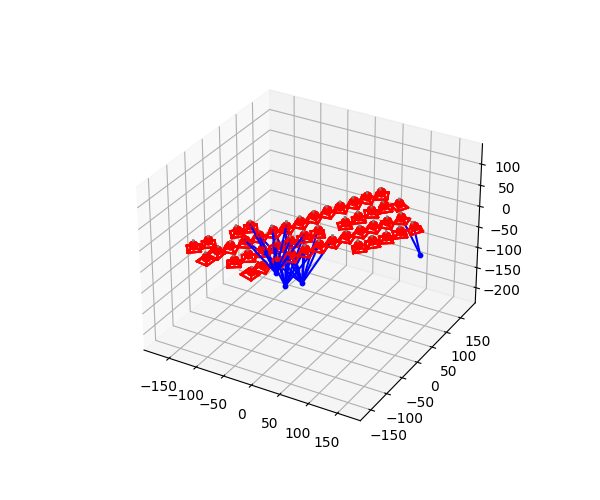

In [11]:
plt.figure(figsize=(6,5))
ax = plt.axes(projection='3d')
ax.scatter3D(views_pos[:,0], views_pos[:,1], views_pos[:,2], c='r', s=10)
if points_gt is not None:
    ax.scatter3D(points_gt[:, 0], points_gt[:, 1], points_gt[:, 2], c='r', s=10)
points_vis = points_lidar
for i in range(points_vis.shape[0]):
    P_w = points_vis[i, :]
    ax.scatter3D(P_w[0], P_w[1], P_w[2], c='b', s=10)
    for k in range(n_views):
        plot_fustrum(ax, views_pos[k], views_rot[k], f=-1.0, scale=10)
    for backprojection in backprojections[i]:
        cam_idx = backprojection[0]
        ax.plot3D([P_w[0], views_pos[cam_idx,0]], 
                     [P_w[1], views_pos[cam_idx,1]], 
                     [P_w[2], views_pos[cam_idx, 2]], 'b-')
set_3d_axes_equal(ax)

## Solution #1

In [12]:
points_hat = []
for k, backprojection_data in enumerate(backprojections):
    result, P_hat = triangulate(np.array(backprojection_data), pixel2camera, views_rot, views_pos)
    points_hat.append(P_hat)
    
    if points_gt is not None:
        print('Check triangulation (~=0): ', np.linalg.norm(P_hat - points_gt[k]))   
        
points_hat = np.array(points_hat)

print('Points to lidar: ')   
print(points_hat - points_lidar)


Points to lidar: 
[[ -1.39997856   0.28251267 -32.71545623]
 [ -1.21692108   1.14188195 -32.22690746]
 [ -1.12400277   1.25625934 -32.17050946]
 [ -0.80306958   1.09809847 -32.12796697]]


Input lidar & point cloud coordinates

In [13]:
np.set_printoptions(precision=2, suppress = True)

print('Lidar points')
print(points_lidar + bundle_mean_offset)

print('Triangulated points')
print(points_hat + bundle_mean_offset)

print('Are these points the same (should be not ~=0): ', np.linalg.norm(points_lidar-points_hat))

Lidar points
[[540825.86 127060.95    276.27]
 [540704.79 126897.92    270.62]
 [540684.4  126880.9     267.57]
 [540653.43 126904.21    270.62]]
Triangulated points
[[540824.46 127061.23    243.55]
 [540703.57 126899.06    238.39]
 [540683.28 126882.16    235.4 ]
 [540652.63 126905.31    238.49]]
Are these points the same (should be not ~=0):  64.69574512131885


In [14]:
def find_rigid_transformation(pts_model, pts_target):
    cog_model = np.mean(pts_model, axis=0)
    cog_target = np.mean(pts_target, axis=0)

    pts_model_cog = pts_model - cog_model
    pts_target_cog = pts_target - cog_target

    s1 = 0
    s2 = 0
    for k in range(pts_model_cog.shape[0]):
        s1 += pts_model_cog[k].dot(pts_model_cog[k]) 
        s2 += pts_target_cog[k].dot(pts_target_cog[k]) 
    scale = np.sqrt(s2/s1)
    pts_model_cog = scale * pts_model_cog

    C = pts_model_cog.T @ pts_target_cog

    [U, S, V] = np.linalg.svd(C)
    V = V.T

    R_hat = V @ U.T
    t_hat = cog_target - scale * R_hat @ cog_model

    
    return True, R_hat, t_hat, scale

result, R_hat, t_hat, s_hat = find_rigid_transformation(points_lidar, points_hat) 
points_lidar_hat = (s_hat * R_hat @ points_lidar.T).T + t_hat

res_svd = np.linalg.norm(points_lidar_hat - points_hat, axis=1)
print('Check transformation (if synthetic data then ~=0)', np.linalg.norm(res_svd))

print('Point set to point set distance:')
print('  before:', np.linalg.norm(points_lidar - points_hat))
print('  after: ', np.linalg.norm(points_lidar_hat - points_hat))
print(' ')
print('R_hat: ', Rotation.from_matrix(R_hat).as_euler('ZYX', degrees=True))
print('t_hat: ', t_hat)
print('scale: ', s_hat)

Check transformation (if synthetic data then ~=0) 0.16317138710101936
Point set to point set distance:
  before: 64.69574512131885
  after:  0.1631713871010194
 
R_hat:  [-0.08  0.14 -0.06]
t_hat:  [ -0.84   1.08 -32.69]
scale:  0.995708477440897


In [15]:
def get_T(R, t, s):
    T = np.vstack((np.hstack((s*R, np.array([t]).T)), [[0, 0, 0, 1]]))
    for i in range(4):
        row = ''
        for j in range(4):
            row += '{:.8f} '.format(T[i, j])
        print(row)
    return T

_ = get_T(R_hat, t_hat, s_hat)

0.99570471 0.00135773 0.00238057 -0.84378088 
-0.00136010 0.99570706 0.00099035 1.08236247 
-0.00237922 -0.00099360 0.99570514 -32.69315845 
0.00000000 0.00000000 0.00000000 1.00000000 


In [16]:
#for gcp_idx, gcp in enumerate(gcps):
#    print(gcp_idx, gcp['XYZ'])

errors = points_lidar_hat - points_hat
for k in range(errors.shape[0]):
    num2str = lambda x: str(round(x, 3))
    print('dx= ' + num2str(errors[k, 0]) + ' dy= ' + num2str(errors[k, 1]) + ' dz= ' + num2str(errors[k, 2]))

dx= -0.022 dy= -0.017 dz= 0.001
dx= 0.081 dy= -0.018 dz= -0.013
dx= 0.045 dy= -0.034 dz= 0.009
dx= -0.104 dy= 0.069 dz= 0.004


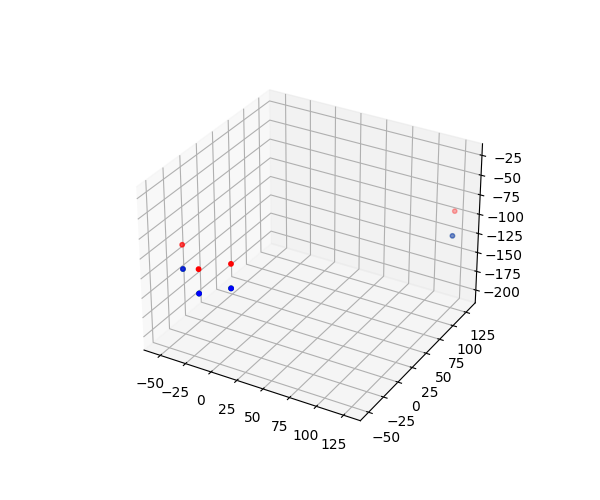

In [17]:
plt.figure(figsize=(6,5))
ax = plt.axes(projection='3d')
if points_gt is not None:
    ax.scatter3D(points_gt[:, 0], points_gt[:, 1], points_gt[:, 2], c='g', s=10)
ax.scatter3D(points_hat[:, 0], points_hat[:, 1], points_hat[:, 2], c='g', s=10)
ax.scatter3D(points_lidar[:, 0], points_lidar[:, 1], points_lidar[:, 2], c='r', s=10)
ax.scatter3D(points_lidar_hat[:, 0], points_lidar_hat[:, 1], points_lidar_hat[:, 2], c='b', s=10)
set_3d_axes_equal(ax)

# Solution #2

$$
\min_{R,\mathbf{t}} \sum_i \frac{ \lVert d_i \times (C_i - (RP_i + t)) \lVert }{ \lVert d_i \lVert}
$$
where $C_i$ is the camera center, $d_i$ is the direction vector of ray corresponging to the $i$th image point and $P_i$ is the lidar point.

In [18]:
from scipy.optimize import least_squares

In [19]:
def get_Rt(x):
    R = Rotation.from_euler('ZYX', x[0:3], degrees=False).as_matrix()
    t = x[3:6]
    s = x[6]
    return R, t, s

def skew(x): return np.array([[0, -x[2], x[1]],
                                 [x[2], 0, -x[0]],
                                 [-x[1], x[0], 0]])

def cost_fn(x):
    R, t, s = get_Rt(x)
    
    residuals = []
    for gcp_idx, backprojection_data in enumerate(backprojections):
        P = (np.array(gcps[gcp_idx]['XYZ']) - bundle_mean_offset).T
        for k, backprojection_data in enumerate(backprojection_data):
            cam_idx = int(backprojection_data[0])
            R_view = views_rot[cam_idx]
            C_view = views_pos[cam_idx]
            img_pt = np.array(backprojection_data)[1:3]

            result, p_c = pixel2camera(img_pt)
            x_i = f*p_c[0];
            y_i = f*p_c[1];
            z_i = -f

            d_c = np.array([x_i, y_i, z_i]).T
            d_w = R_view.T @ d_c
            d_w = d_w / np.linalg.norm(d_w)

            #ray_to_point = np.cross(d_w, C_view - (R @ P + t))
            ray_to_point = skew(d_w) @ (C_view - (s * R @ P + t)) # let's use only ordanary matrix operations
            residuals.append(ray_to_point.T)
            
    return np.array(residuals).flatten()
    

In [20]:
x0 = [0, 0, 0, 0, 0, 0, 1.0]
residuals_0 = cost_fn(x0)
res = least_squares(cost_fn, x0, verbose=1)

`ftol` termination condition is satisfied.
Function evaluations 11, initial cost 1.6631e+03, final cost 9.8637e-02, first-order optimality 2.36e-06.


In [21]:
print('Solution #1')
print('   R_hat: ', Rotation.from_matrix(R_hat).as_euler('ZYX', degrees=True))
print('   t_hat: ', t_hat)
print('   s_hat: ', s_hat)

print('Solution #2')
R_hat_2, t_hat_2, s_hat_2 = get_Rt(res.x)
print('   R_hat: ', Rotation.from_matrix(R_hat_2).as_euler('ZYX', degrees=True))
print('   t_hat: ', t_hat_2)
print('   s_hat: ', s_hat_2)

Solution #1
   R_hat:  [-0.08  0.14 -0.06]
   t_hat:  [ -0.84   1.08 -32.69]
   s_hat:  0.995708477440897
Solution #2
   R_hat:  [-0.08  0.07  0.09]
   t_hat:  [ -0.98   0.81 -32.7 ]
   s_hat:  0.9949939609341858


In [22]:
_ = get_T(R_hat_2, t_hat_2, s_hat_2)

0.99499220 0.00146300 0.00116964 -0.98277705 
-0.00146123 0.99499175 -0.00150708 0.80512511 
-0.00117186 0.00150536 0.99499213 -32.69623575 
0.00000000 0.00000000 0.00000000 1.00000000 


# Comparison

Statistics at initial guess:

In [23]:
print('Aprior statistics: ')
print('Average distance error', np.mean(residuals_0))
print('Average abs. distance error', np.mean(np.abs(residuals_0)))

def compare_to_triangulation(R, t, s):
    points_lidar_hat = (s * R @ points_lidar.T).T + t
    np.set_printoptions(precision=4, suppress = True)
    print(points_lidar_hat - points_hat)
    print('Norm of the differences: ', np.linalg.norm(points_lidar_hat - points_hat))
    print('Max difference: ', np.max(np.linalg.norm(points_lidar_hat - points_hat, axis=1)))
    print('Avg. difference: ', np.mean(np.linalg.norm(points_lidar_hat - points_hat, axis=1)))

R0, t0, s0 = get_Rt(x0)
compare_to_triangulation(R0, t0, s0)

Aprior statistics: 
Average distance error 0.6639709159032475
Average abs. distance error 4.074359182506986
[[ 1.4    -0.2825 32.7155]
 [ 1.2169 -1.1419 32.2269]
 [ 1.124  -1.2563 32.1705]
 [ 0.8031 -1.0981 32.128 ]]
Norm of the differences:  64.69574512131885
Max difference:  32.746615549663126
Avg. difference:  32.34702504655029


Let's check the average point-ray distance after adjustment and compare the transformation to the triangulated points:

In [24]:
residuals = cost_fn(res.x)
print('Average distance error', np.mean(residuals))
print('Average abs. distance error', np.mean(np.abs(residuals)))
print(' ')
print('Comparison to the triangulated points:')
compare_to_triangulation(R_hat_2, t_hat_2, s_hat_2)

Average distance error -0.000542916700534431
Average abs. distance error 0.03405094486708891
 
Comparison to the triangulated points:
[[-0.1218 -0.1661  0.5376]
 [ 0.0563 -0.0236 -0.0262]
 [ 0.0371 -0.0183 -0.0691]
 [-0.0911  0.0637 -0.0555]]
Norm of the differences:  0.598137505397702
Max difference:  0.5756979270634393
Avg. difference:  0.2117328921112151


Let's look at these error metrics in case of the triangulation + SVD approach

In [25]:
ypr = Rotation.from_matrix(R_hat).as_euler('ZYX', degrees=False)
x_hat = [ypr[0], ypr[1], ypr[2], t_hat[0], t_hat[1], t_hat[2], s_hat]

R_test, t_test, s_test = get_Rt(x_hat)
print('~=0: ', np.linalg.norm(R_test - R_hat))
print('~=0: ', np.linalg.norm(t_test - t_hat))
print('~=0: ', np.linalg.norm(s_test - s_hat))

residuals = cost_fn(x_hat)
print('Average distance error', np.mean(residuals))
print('Average abs. distance error', np.mean(np.abs(residuals)))
print(' ')
print('Comparison to the triangulated points:')
compare_to_triangulation(R_hat, t_hat, s_hat)

~=0:  2.0967135743236979e-16
~=0:  0.0
~=0:  0.0
Average distance error 0.001975280930431963
Average abs. distance error 0.03953260819520307
 
Comparison to the triangulated points:
[[-0.0215 -0.0172  0.0009]
 [ 0.0806 -0.0176 -0.0133]
 [ 0.0449 -0.0342  0.0088]
 [-0.1041  0.069   0.0037]]
Norm of the differences:  0.1631713871010194
Max difference:  0.12492295819511588
Avg. difference:  0.07331671749469802


## Solution #2.1

In [26]:
from collections import defaultdict
import math

class AutoDiffVariable(object):
    
    def __init__(self, value, local_gradients=[]):
        self.value = float(value)
        self.local_gradients = local_gradients

    def __float__(self):
         return self.value
    
    def __add__(self, other):
        if not isinstance(other, AutoDiffVariable):
            return self.__add__(AutoDiffVariable(float(other)))        
        value = self.value + other.value    
        local_gradients = ((self, 1.0), (other, 1.0))
        return AutoDiffVariable(value, local_gradients)
    
    def __mul__(self, other):
        if not isinstance(other, AutoDiffVariable):
            return self.__mul__(AutoDiffVariable(float(other)))
        value = self.value * other.value
        local_gradients = ((self, other.value), (other, self.value))
        return AutoDiffVariable(value, local_gradients)

    def __neg__(self):
        value = -1.0 * self.value
        local_gradients = ((self, -1.0),)
        return AutoDiffVariable(value, local_gradients)
    
    def __sub__(self, other):
        if not isinstance(other, AutoDiffVariable):
            return self.__sub__(AutoDiffVariable(float(other)))        
        return self.__add__(other.__neg__())
    
    def __repr__(self):
        return str(self.value) + 'v' # + ' [' + str(self.local_gradients) + ']'

    def __inv__(self):
        value = 1. / self.value
        local_gradients = (
            (self, -1 / self.value**2),
        )
        return AutoDiffVariable(value, local_gradients)

    def __truediv__(self, other):
        if not isinstance(other, AutoDiffVariable):
            return self.__truediv__(AutoDiffVariable(float(other)))         
        return self.__mul__(other.__inv__()) 
    
    def __pow__(self, other):
        if not isinstance(other, AutoDiffVariable):
            return self.__pow__(AutoDiffVariable(float(other)))                
        value = self.value ** other.value
        local_gradients = ((self,  other.value*self.value**(other.value-1) ), 
                           (other, self.value**other.value*math.log(other.value)))
        return AutoDiffVariable(value, local_gradients)    
    
    __radd__  = __add__
    __rmul__ = __mul__
    __rsub__ = __sub__

class AutoDiffFunctions(object):
    
    @staticmethod
    def sin(a):
        value = np.sin(a.value)
        local_gradients = (
            (a, np.cos(a.value)),
        )
        return AutoDiffVariable(value, local_gradients)
    
    @staticmethod
    def cos(a):
        value = np.cos(a.value)
        local_gradients = (
            (a, -np.sin(a.value)),
        )
        return AutoDiffVariable(value, local_gradients)

    @staticmethod
    def skew(x): 
        var = AutoDiffVariable
        return np.array([[var(0), -x[2], x[1]],
                         [x[2], var(0), -x[0]],
                         [-x[1], x[0], var(0)]])
    @staticmethod
    def matexp(w):
        sin = AutoDiffFunctions.sin
        cos = AutoDiffFunctions.cos
        var = AutoDiffVariable
        if np.sum(np.abs(w.astype('float'))) < 1e-10:
            omega = var(1)
        else:
            omega = (w[0]**2 + w[1]**2 + w[2]**2)**(1/2)
        S = skew(w)
        R = np.eye(3) + S*(sin(omega)/omega) + S@S*((var(1)-cos(omega))/omega**2)
        return R


vf = AutoDiffFunctions
_var = AutoDiffVariable
np2var = lambda vec: np.array([AutoDiffVariable(x) for x in vec])

In [27]:
def get_gradients(variable):
    
    gradients = defaultdict(lambda: 0)
    
    def compute_gradients(variable, path_value):
        for child_variable, local_gradient in variable.local_gradients:
            # "Multiply the edges of a path":
            value_of_path_to_child = path_value * local_gradient
            # "Add together the different paths":
            gradients[child_variable] += value_of_path_to_child
            # recurse through graph:
            compute_gradients(child_variable, value_of_path_to_child)
    
    compute_gradients(variable, path_value=1)
    # (path_value=1 is from `variable` differentiated w.r.t. itself)
    return gradients

def compute_jacobian(r, x):
    m = r.shape[0]
    n = len(x)
    J = np.zeros((m, n))
    for iter_r in range(m):
        grad_iter = get_gradients(r[iter_r])
        for iter_x in range(n):
            J[iter_r, iter_x] = grad_iter[x[iter_x]]
    return J

In [28]:
test_a = _var(3)
test_b = _var(4)
test_c = (test_a**2 + test_b**2)**(_var(1)/_var(2))
print('Test value ( =5): ', test_c.value)
print('Local gradient ( not =[]): ', test_c.local_gradients)

Test value ( =5):  5.0
Local gradient ( not =[]):  ((25.0v, 0.1), (0.5v, -3.4657359027997265))


In [29]:
def Exp_(w):
    omega = (w[0]**2 + w[1]**2 + w[2]**2)**(1/2)
    if omega < 1e-10:
        return np.eye(3)
    S = np.array([[0, -w[2], w[1]], [w[2], 0, -w[0]], [-w[1], w[0], 0]])
    return np.eye(3) + S*(math.sin(omega)/omega) + S@S*((1-math.cos(omega))/omega**2)

rvec_gt = Rotation.from_matrix(R_hat).as_rotvec(degrees=False)
print('Check exponential map: ', np.linalg.norm(Exp_(rvec_gt) - R_hat))

Check exponential map:  3.2479034622852325e-16


In [30]:
def Log_(R):
    omega = np.arccos((np.trace(R)-1)/2)           # input rotation matrix
    S = (omega/(2*np.sin(omega))) * (R-R.T)        # rotation matrix SO(3) -> skew so(3)
    return [S[2, 1], S[0, 2], S[1, 0]]             # so(3) -> R^3, using the def. of skew matrix

In [31]:
method = 1 # 1 - rotation vector optimization, 2 - optimization on manifold
x0 = [0, 0, 0, 0, 0, 0, 1.0]

#w = Log_(R_hat)
#x0 = np.hstack((w, t_hat))

R = Exp_(x0[:3])
t = x0[3:6]
s = x0[6]

dx = np.inf
iter_num = 0

while np.linalg.norm(dx) > 1e-8 and iter_num < 20:
    iter_num += 1
    
    J = []
    dr = []
    for gcp_idx, backprojection_data in enumerate(backprojections):
        P = (np.array(gcps[gcp_idx]['XYZ']) - bundle_mean_offset).T
        for k, backprojection_data in enumerate(backprojection_data):
            cam_idx = int(backprojection_data[0])
            R_view = views_rot[cam_idx]
            C_view = views_pos[cam_idx]
            img_pt = np.array(backprojection_data)[1:3]

            result, p_c = pixel2camera(img_pt)
            d_c = np.array([f*p_c[0], f*p_c[1], -f]).T
            d_w = R_view.T @ d_c
            d_w = d_w / np.linalg.norm(d_w)

            d_w_var = np2var(d_w)           

            if method == 1:
                x = np2var(x0)
                res_entry = vf.skew(d_w_var) @ (C_view - (np.array([x[6]]) * vf.matexp(x[:3]) @ P + x[3:6]))
            else:
                x = np2var([0, 0, 0, 0, 0, 0, 0.0])
                q = vf.matexp(x[:3]) @ P
                dq = skew(-P)
                res_entry = vf.skew(d_w_var) @ (C_view - (np.array([s + x[6]]) * R @ q + (t + x[3:6])))

            jac_entry = compute_jacobian(res_entry, x)

            # Directly optimizing norm has longer convergence
            #res_entry = (res_entry[0]**2 + res_entry[1]**2 + res_entry[2]**2)**0.5
            #dr.append(float(res_entry))
            #jac_entry = compute_jacobian(np.array([res_entry]), x)
            
            dr.append(res_entry.astype('float'))
            J.append(jac_entry)

    dr = np.array(dr).flatten()
    J = np.array(J).reshape(-1, 7) 

    dx = np.linalg.solve(-J.T @ J, J.T @ dr)
    #dx = -np.linalg.inv(J.T @ J) @ J.T @ dr
    if method == 1:
        x0 = x0 + dx
        
    #print(dx)

    if method == 1:
        R = Exp_(x0[:3])
        t = x0[3:6]
        s = x0[6]
    else:
        R = R @ Exp_(dx[:3])
        t = t + dx[3:6]
        s = s + dx[6]
    
    print('Iteration #{:d} \t R: {:.6f} \t t: {:.4f} \t dx: {:.8f}\t dr: {:.8f}'.format(
         iter_num, np.linalg.norm(R - R_hat_2), np.linalg.norm(t - t_hat_2), 
         np.linalg.norm(dx), np.linalg.norm(dr)))


Iteration #1 	 R: 0.000541 	 t: 0.0070 	 dx: 32.72187018	 dr: 57.67295159
Iteration #2 	 R: 0.000013 	 t: 0.0009 	 dx: 0.00792338	 dr: 0.50549244
Iteration #3 	 R: 0.000001 	 t: 0.0000 	 dx: 0.00090142	 dr: 0.44415562
Iteration #4 	 R: 0.000000 	 t: 0.0000 	 dx: 0.00003820	 dr: 0.44415553
Iteration #5 	 R: 0.000000 	 t: 0.0000 	 dx: 0.00000153	 dr: 0.44415553
Iteration #6 	 R: 0.000000 	 t: 0.0000 	 dx: 0.00000006	 dr: 0.44415553
Iteration #7 	 R: 0.000000 	 t: 0.0000 	 dx: 0.00000000	 dr: 0.44415553


In [32]:
ypr = Rotation.from_matrix(R).as_euler('ZYX', degrees=False)
x_hat = [ypr[0], ypr[1], ypr[2], t[0], t[1], t[2], s]

residuals = cost_fn(x_hat)
print('Average distance error', np.mean(residuals))
print('Average abs. distance error', np.mean(np.abs(residuals)))
print(' ')
print('Comparison to the triangulated points:')
compare_to_triangulation(R, t, s)

Average distance error -0.0005429165076606864
Average abs. distance error 0.03405094517575348
 
Comparison to the triangulated points:
[[-0.1218 -0.1661  0.5376]
 [ 0.0563 -0.0236 -0.0262]
 [ 0.0371 -0.0183 -0.0691]
 [-0.0911  0.0637 -0.0555]]
Norm of the differences:  0.5981374164630102
Max difference:  0.5756978313460872
Avg. difference:  0.21173286883350734
